# Imports

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
from copy import deepcopy
from functools import partial
from itertools import combinations
import random
import gc

# Import sklearn classes for model selection, cross validation, and performance evaluation
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from sklearn import ensemble
import seaborn as sns
from category_encoders import OneHotEncoder, OrdinalEncoder, CountEncoder, CatBoostEncoder
from imblearn.under_sampling import RandomUnderSampler

# Import libraries for Hypertuning
import optuna

# Import libraries for gradient boosting
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoost, CatBoostRegressor, CatBoostClassifier
from catboost import Pool

# Suppress warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Data

In [2]:
    def fix_columns(df): 
        """Removes (in millions) and (approx).1 from names of columns."""
        df.columns = df.columns.str.replace('(in millions)', '', regex=False)
        df.columns = df.columns.str.replace(' home(approx).1', '_home', regex=False)
        return df

    filepath = '/kaggle/input/playground-series-s3e11'

    df_train = pd.read_csv(os.path.join(filepath, 'train.csv'), index_col=[0])
    df_test = pd.read_csv(os.path.join(filepath, 'test.csv'), index_col=[0])
    original = pd.read_csv('/kaggle/input/media-campaign-cost-prediction/train_dataset.csv')

    df_train = fix_columns(df_train)
    df_test = fix_columns(df_test)
    original = fix_columns(original)

    df_train['is_generated'] = 1
    df_test['is_generated'] = 1
    original['is_generated'] = 0

    original = original.reset_index()
    original['id'] = original['index'] + df_test.index[-1] + 1
    original = original.drop(columns = ['index']).set_index('id')

    target_col = 'cost'

# Simple EDA

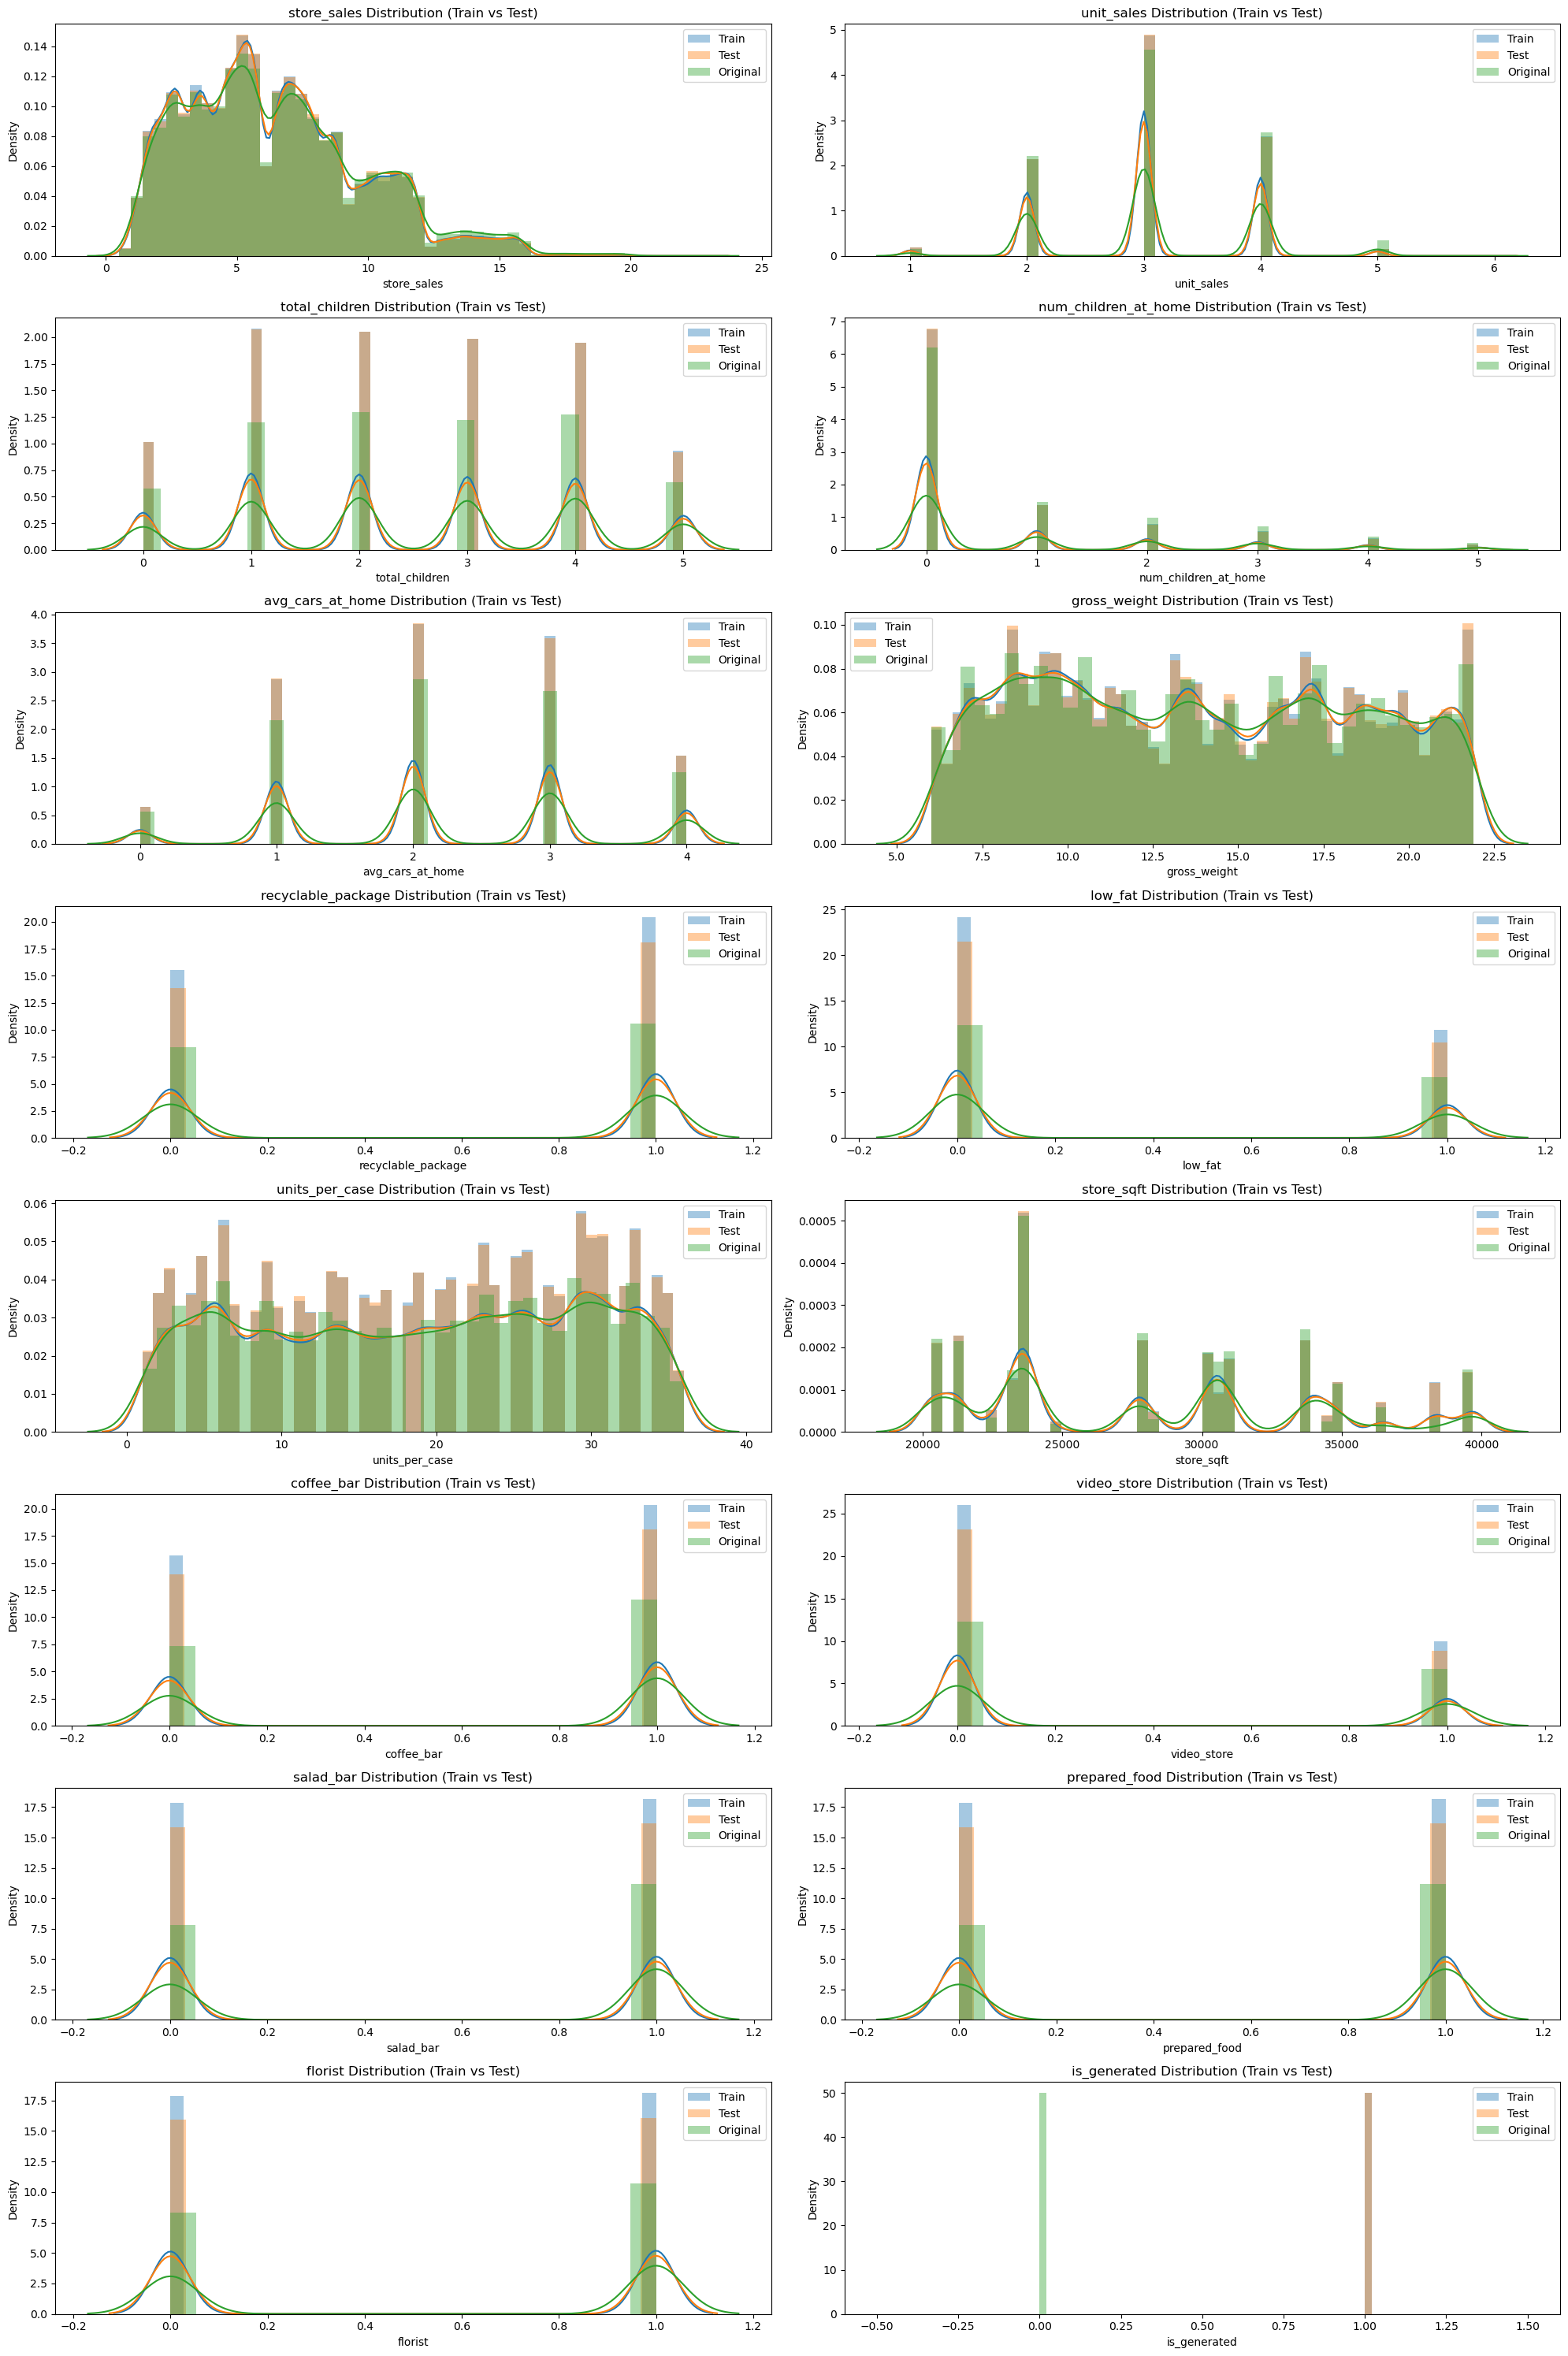

In [3]:
n_cols = 2
n_rows = (len(df_test.columns) - 1) // n_cols + 1

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 30))

for i, var_name in enumerate(df_test.columns.tolist()):
    row = i // n_cols
    col = i % n_cols
    
    ax = axes[row, col]
    sns.distplot(df_train[var_name], kde=True, ax=ax, label='Train')
    sns.distplot(df_test[var_name], kde=True, ax=ax, label='Test')
    sns.distplot(original[var_name], kde=True, ax=ax, label='Original')
    ax.set_title(f'{var_name} Distribution (Train vs Test)')
    ax.legend()
    
plt.tight_layout()
plt.show()

<AxesSubplot:>

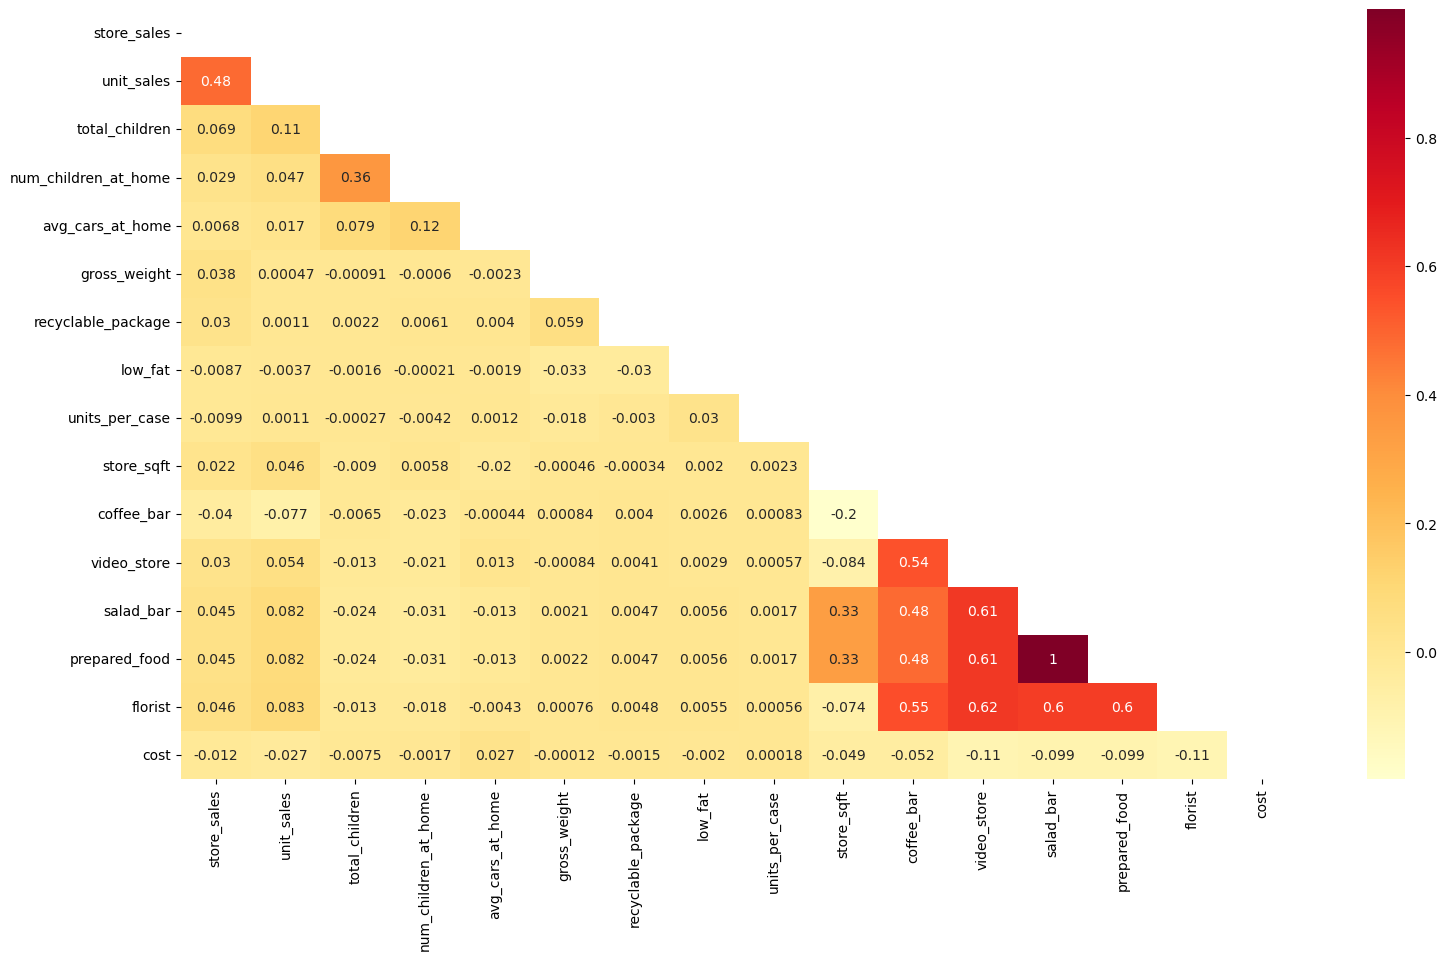

In [4]:
plt.figure(figsize=(18, 10))
mask = np.triu(np.ones_like(df_train.drop('is_generated', axis=1).corr()))
sns.heatmap(df_train.drop('is_generated', axis=1).corr(),cmap='YlOrRd',annot=True,mask=mask)

# Prepare Train and Test sets

In [5]:
def fe(df):
    # kudos to https://www.kaggle.com/code/sergiosaharovskiy/ps-s3e11-2023-eda-and-submission
    df.unit_sales = df.unit_sales.clip(0, 5)
    df['children_ratio'] = df['total_children'] / df['num_children_at_home']
    df['children_ratio'] = df['children_ratio'].replace([np.inf, -np.inf], 10)
    return df

# Apply FE
df_train = fe(df_train)
original = fe(original)
df_test = fe(df_test)

# Concatenate train and original dataframes, and prepare train and test sets
df_train = pd.concat([df_train, original])
X_train = df_train.drop([f'{target_col}'],axis=1).reset_index(drop=True)
y_train = df_train[f'{target_col}'].reset_index(drop=True)
X_test = df_test.reset_index(drop=True)

# Transform the values in y_train using the natural logarithm function
y_train_ori = y_train.copy()
y_train = np.log1p(y_train_ori)

# Drop cols
cols_to_drop = [
    'store_sales', 
    'gross_weight', 
    'unit_sales', 
    'low_fat',
    'recyclable_package', 
    'salad_bar', 
    'units_per_case'
]
X_train.drop(cols_to_drop, axis=1, inplace=True)
X_test.drop(cols_to_drop, axis=1, inplace=True)

print(f"X_train shape :{X_train.shape} , y_train shape :{y_train.shape}")
print(f"X_test shape :{X_test.shape}")

# Delete the train and test dataframes to free up memory
del df_train, df_test

X_train shape :(411699, 10) , y_train shape :(411699,)
X_test shape :(240224, 10)


In [6]:
categorical_columns = [
    'total_children',
    'num_children_at_home',
    'avg_cars_at_home',
    'store_sqft',
    'coffee_bar',
    'video_store',
    'prepared_food'
]

for col in categorical_columns:
    X_train[col] = X_train[col].astype(int)
    X_test[col] = X_test[col].astype(int)

In [7]:
class Splitter:
    def __init__(self, test_size=0.2, kfold=True, n_splits=5):
        self.test_size = test_size
        self.kfold = kfold
        self.n_splits = n_splits

    def split_data(self, X, y, random_state_list):
        if self.kfold:
            for random_state in random_state_list:
                kf = KFold(n_splits=self.n_splits, random_state=random_state, shuffle=True)
                for train_index, val_index in kf.split(X, y):
                    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
                    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
                    yield X_train, X_val, y_train, y_val
        else:
            for random_state in random_state_list:
                X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=self.test_size, random_state=random_state)
                yield X_train, X_val, y_train, y_val

kfold = True
n_splits = 1 if not kfold else 15
random_state = 42
random_state_list = [42] # used by split_data [42, 41, 35]
n_estimators = 9999 # 9999
early_stopping_rounds = 200
verbose = False
device = 'gpu'

splitter = Splitter(kfold=kfold, n_splits=n_splits)

# Define Model

In [8]:
class Regressor:
    def __init__(self, n_estimators=100, device="cpu", random_state=0):
        self.n_estimators = n_estimators
        self.device = device
        self.random_state = random_state
        self.reg_models = self._define_reg_model()
        self.len_models = len(self.reg_models)
        
    def _define_reg_model(self):
        
        xgb_params = {
            'n_estimators': self.n_estimators,
            'learning_rate': 0.05,
            'max_depth': 8,
            'subsample': 1.0,
            'colsample_bytree': 1.0,
            'n_jobs': -1,
            'objective': 'reg:squarederror',
            'verbosity': 0,
            'eval_metric': 'rmse',
            'random_state': self.random_state,
        }
        if self.device == 'gpu':
            xgb_params['tree_method'] = 'gpu_hist'
            xgb_params['predictor'] = 'gpu_predictor'
        
        lgb_params = {
            'n_estimators': self.n_estimators,
            'max_depth': 8,
            'learning_rate': 0.05293702575527996,
            'subsample': 0.20851841295589477,
            'colsample_bytree': 0.5784778854092203,
            'reg_alpha': 0.2622912287429849,
            'reg_lambda': 2.8702494234117617e-08,
            'objective': 'regression',
            'metric': 'rmse',
            'boosting_type': 'gbdt',
            'device': self.device,
            'random_state': self.random_state
        }
        
        cb_params = {
            'iterations': self.n_estimators,
            'depth': 7,
            'learning_rate': 0.12947105266151432,
            'l2_leaf_reg': 0.6169164517797081,
            'random_strength': 0.21235850198764036,
            'max_bin': 212,
            'od_wait': 67,
            'one_hot_max_size': 73,
            'grow_policy': 'Depthwise',
            'bootstrap_type': 'Bayesian',
            'od_type': 'Iter',
            'loss_function': 'RMSE',
            'task_type': self.device.upper(),
            'random_state': self.random_state
        }
        
        reg_models = {
            'xgb_reg': xgb.XGBRegressor(**xgb_params),
            'lgb_reg': lgb.LGBMRegressor(**lgb_params),
            'cat_reg': CatBoostRegressor(**cb_params)
        }

        return reg_models

In [9]:
class OptunaWeights:
    def __init__(self, random_state):
        self.study = None
        self.weights = None
        self.random_state = random_state

    def _objective(self, trial, y_true, y_preds):
        # Define the weights for the predictions from each model
        weights = [trial.suggest_float(f"weight{n}", 0, 1) for n in range(len(y_preds))]

        # Calculate the weighted prediction
        weighted_pred = np.average(np.array(y_preds).T, axis=1, weights=weights)

        # Calculate the RMSLE score for the weighted prediction
        score = np.sqrt(mean_squared_log_error(y_true, weighted_pred))
        return score

    def fit(self, y_true, y_preds, n_trials=300):
        optuna.logging.set_verbosity(optuna.logging.ERROR)
        sampler = optuna.samplers.CmaEsSampler(seed=self.random_state)
        self.study = optuna.create_study(sampler=sampler, study_name="OptunaWeights", direction='minimize')
        objective_partial = partial(self._objective, y_true=y_true, y_preds=y_preds)
        self.study.optimize(objective_partial, n_trials=n_trials)
        self.weights = [self.study.best_params[f"weight{n}"] for n in range(len(y_preds))]

    def predict(self, y_preds):
        assert self.weights is not None, 'OptunaWeights error, must be fitted before predict'
        weighted_pred = np.average(np.array(y_preds).T, axis=1, weights=self.weights)
        return weighted_pred

    def fit_predict(self, y_true, y_preds, n_trials=300):
        self.fit(y_true, y_preds, n_trials=n_trials)
        return self.predict(y_preds)
    
    def weights(self):
        return self.weights

# Train Model

In [10]:
# Initialize an array for storing test predictions
test_predss = np.zeros(X_test.shape[0])
ensemble_score = []
weights = []
trained_models = dict(zip(Regressor().reg_models.keys(), [[] for _ in range(Regressor().len_models)]))

# Evaluate on validation data and store predictions on test data
for i, (X_train_, X_val, y_train_, y_val) in enumerate(splitter.split_data(X_train, y_train, random_state_list=random_state_list)):
    n = i % n_splits
    m = i // n_splits
        
    # Get a set of Regressor models
    reg = Regressor(n_estimators, device, random_state)
    models = reg.reg_models
    
    # Initialize lists to store oof and test predictions for each base model
    oof_preds = []
    test_preds = []
    
    # Loop over each base model and fit it to the training data, evaluate on validation data, and store predictions
    for name, model in models.items():
        if name == 'cat_reg':
            train_pool = Pool(X_train_, y_train_, cat_features=categorical_columns)
            test_pool = Pool(X_val, y_val ,cat_features=categorical_columns)
            model.fit(train_pool, eval_set=[test_pool], early_stopping_rounds=early_stopping_rounds, verbose=verbose)
        elif name == 'lgb_reg':
            model.fit(X_train_, y_train_, eval_set=[(X_val, y_val)], 
                      categorical_feature=categorical_columns, early_stopping_rounds=early_stopping_rounds, verbose=verbose)
        else:
            model.fit(X_train_, y_train_, eval_set=[(X_val, y_val)], early_stopping_rounds=early_stopping_rounds, verbose=verbose)
        y_val_pred = model.predict(X_val)
        test_pred = model.predict(X_test)
        
        # Convert predicted values back to their original scale by applying the expm1 function
        y_val_pred = np.expm1(y_val_pred)
        test_pred = np.expm1(test_pred)
        
        score = np.sqrt(mean_squared_log_error(np.expm1(y_val), y_val_pred))
        print(f'{name} [FOLD-{n} SEED-{random_state_list[m]}] RMSLE score: {score:.5f}')
        
        oof_preds.append(y_val_pred)
        test_preds.append(test_pred)
        trained_models[f'{name}'].append(deepcopy(model))
    
    # Use Optuna to find the best ensemble weights
    y_val = np.expm1(y_val)
    optweights = OptunaWeights(random_state=random_state)
    y_val_pred = optweights.fit_predict(y_val.values, oof_preds)
    score = np.sqrt(mean_squared_log_error(y_val, y_val_pred))
    print(f'Ensemble [FOLD-{n} SEED-{random_state_list[m]}] RMSLE score {score:.5f}')
    ensemble_score.append(score)
    weights.append(optweights.weights)
    test_predss += optweights.predict(test_preds) / (n_splits * len(random_state_list))
    
gc.collect()

xgb_reg [FOLD-0 SEED-42] RMSLE score: 0.29297
lgb_reg [FOLD-0 SEED-42] RMSLE score: 0.29297
cat_reg [FOLD-0 SEED-42] RMSLE score: 0.29299
Ensemble [FOLD-0 SEED-42] RMSLE score 0.29289
xgb_reg [FOLD-1 SEED-42] RMSLE score: 0.29471
lgb_reg [FOLD-1 SEED-42] RMSLE score: 0.29464
cat_reg [FOLD-1 SEED-42] RMSLE score: 0.29467
Ensemble [FOLD-1 SEED-42] RMSLE score 0.29457
xgb_reg [FOLD-2 SEED-42] RMSLE score: 0.29310
lgb_reg [FOLD-2 SEED-42] RMSLE score: 0.29314
cat_reg [FOLD-2 SEED-42] RMSLE score: 0.29317
Ensemble [FOLD-2 SEED-42] RMSLE score 0.29303
xgb_reg [FOLD-3 SEED-42] RMSLE score: 0.29364
lgb_reg [FOLD-3 SEED-42] RMSLE score: 0.29368
cat_reg [FOLD-3 SEED-42] RMSLE score: 0.29363
Ensemble [FOLD-3 SEED-42] RMSLE score 0.29357
xgb_reg [FOLD-4 SEED-42] RMSLE score: 0.29443
lgb_reg [FOLD-4 SEED-42] RMSLE score: 0.29429
cat_reg [FOLD-4 SEED-42] RMSLE score: 0.29444
Ensemble [FOLD-4 SEED-42] RMSLE score 0.29425
xgb_reg [FOLD-5 SEED-42] RMSLE score: 0.29193
lgb_reg [FOLD-5 SEED-42] RMSLE sco

77

In [11]:
# Calculate the mean LogLoss score of the ensemble
mean_score = np.mean(ensemble_score)
std_score = np.std(ensemble_score)
print(f'Ensemble RMSLE score {mean_score:.5f} ± {std_score:.5f}')

# Print the mean and standard deviation of the ensemble weights for each model
print('--- Model Weights ---')
mean_weights = np.mean(weights, axis=0)
std_weights = np.std(weights, axis=0)
for name, mean_weight, std_weight in zip(models.keys(), mean_weights, std_weights):
    print(f'{name} {mean_weight: .5f} ± {std_weight: .5f}')

Ensemble RMSLE score 0.29344 ± 0.00101
--- Model Weights ---
xgb_reg  0.31313 ±  0.24937
lgb_reg  0.65809 ±  0.14603
cat_reg  0.40765 ±  0.28032


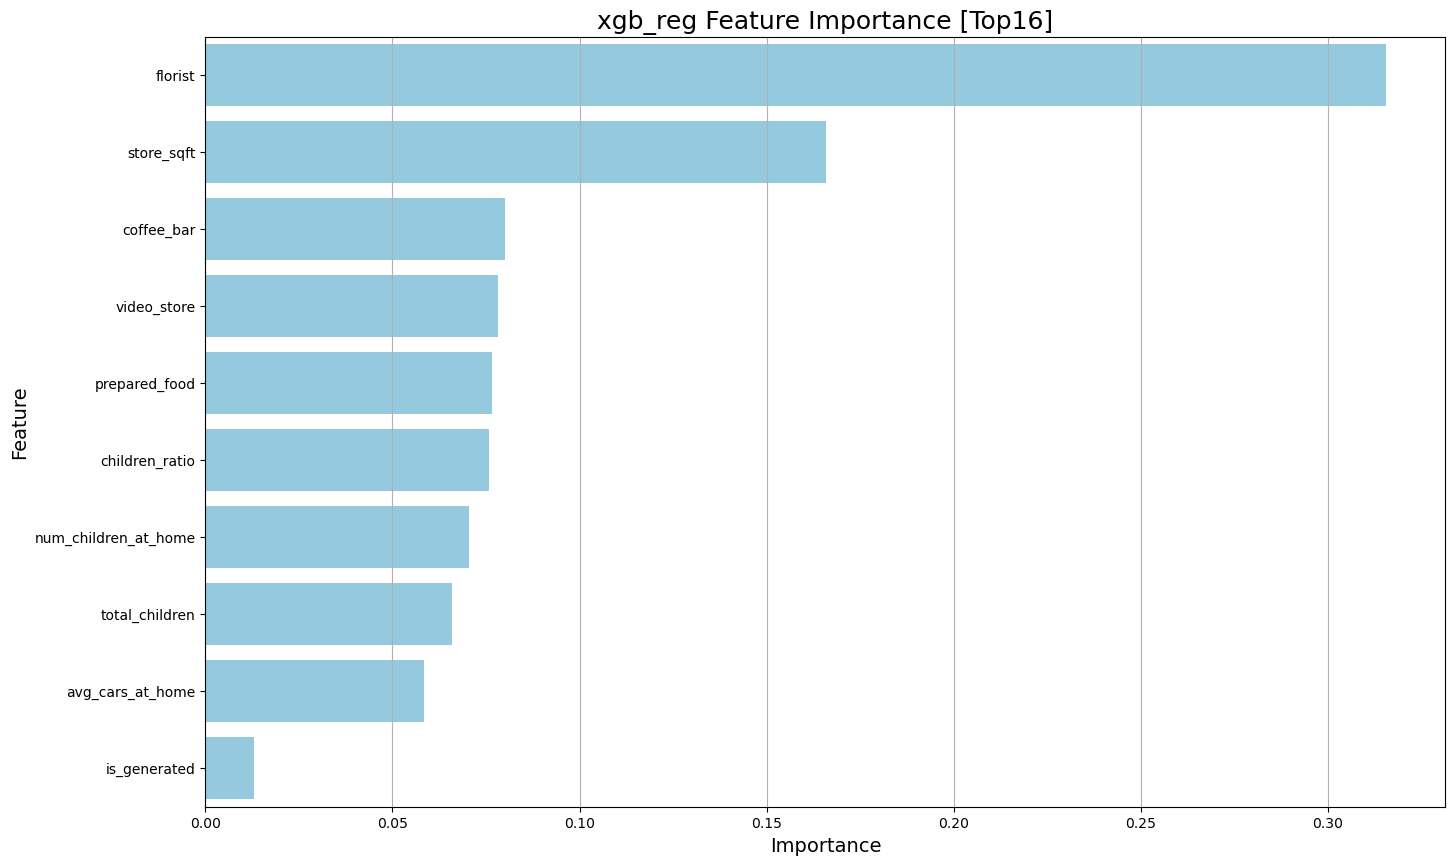

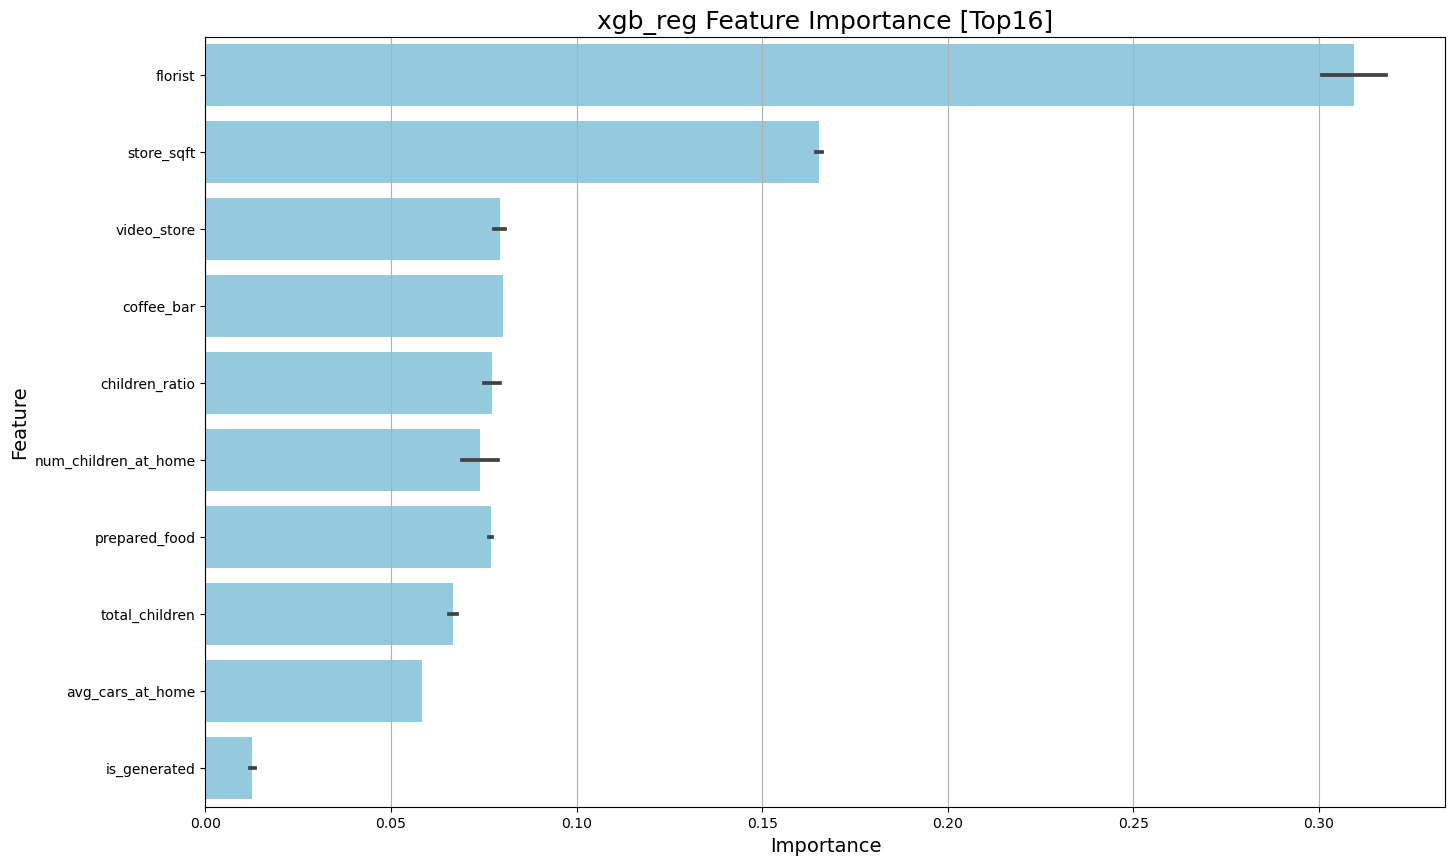

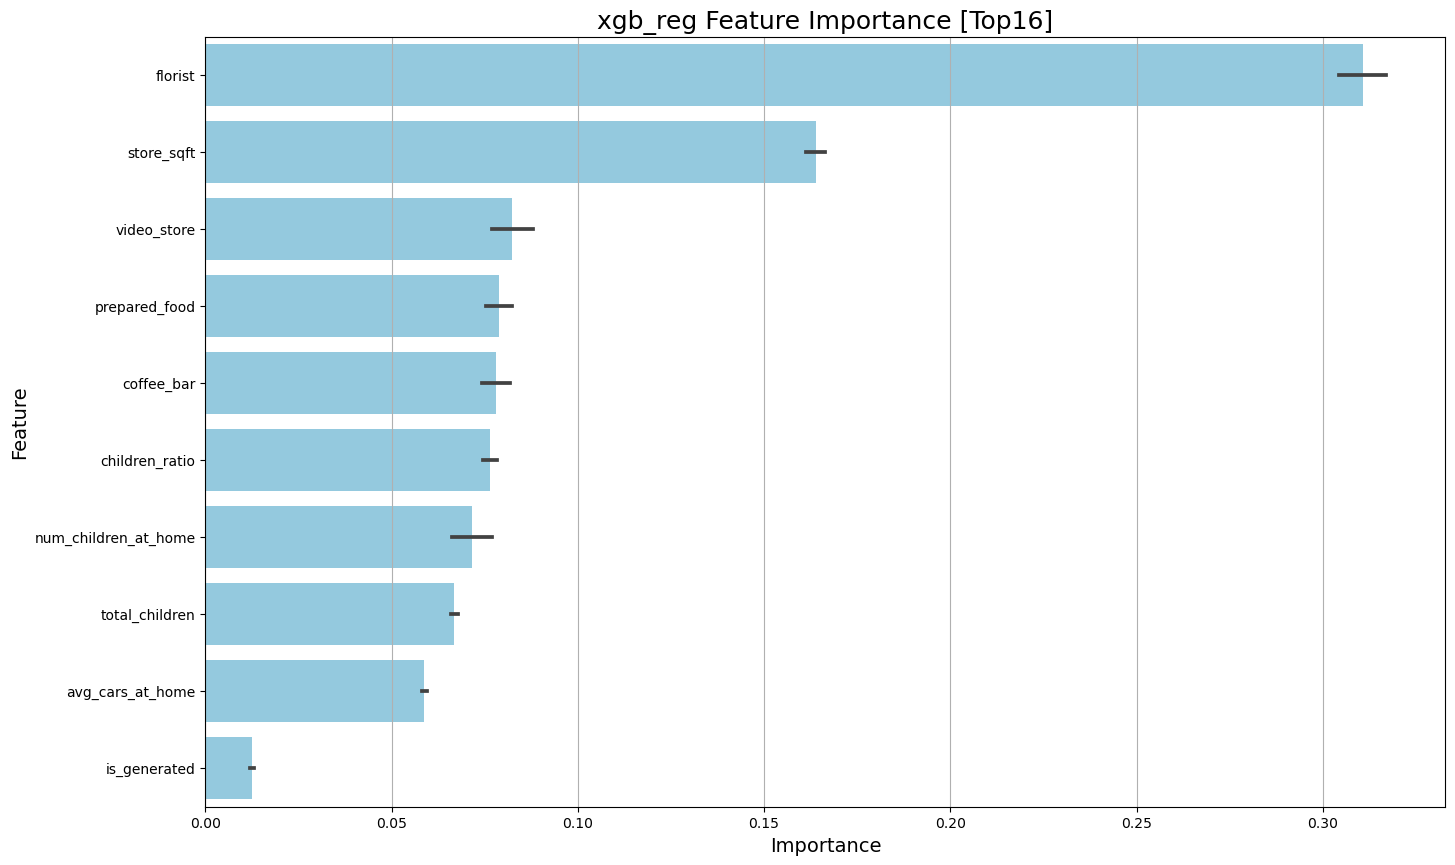

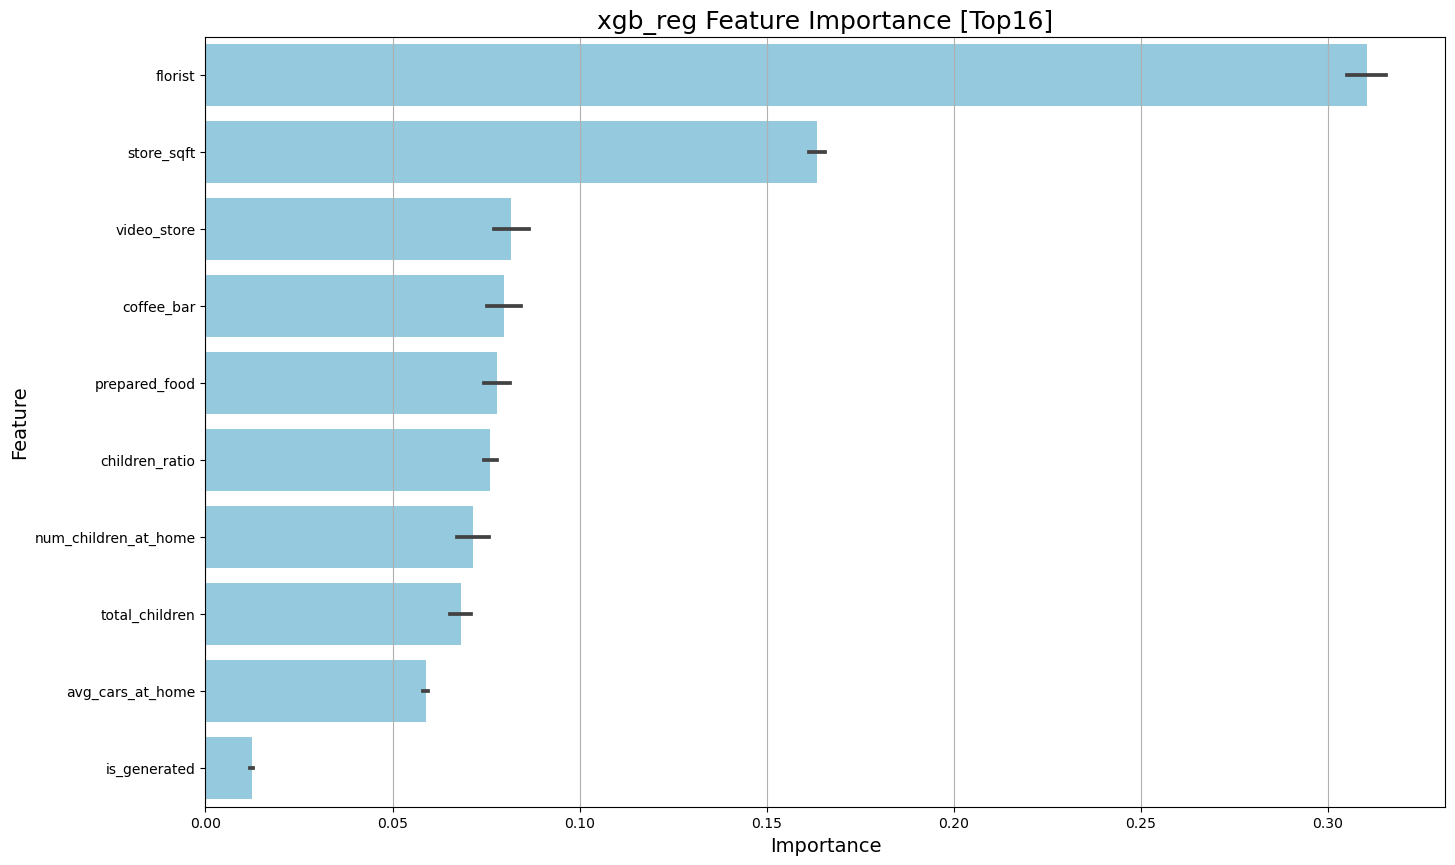

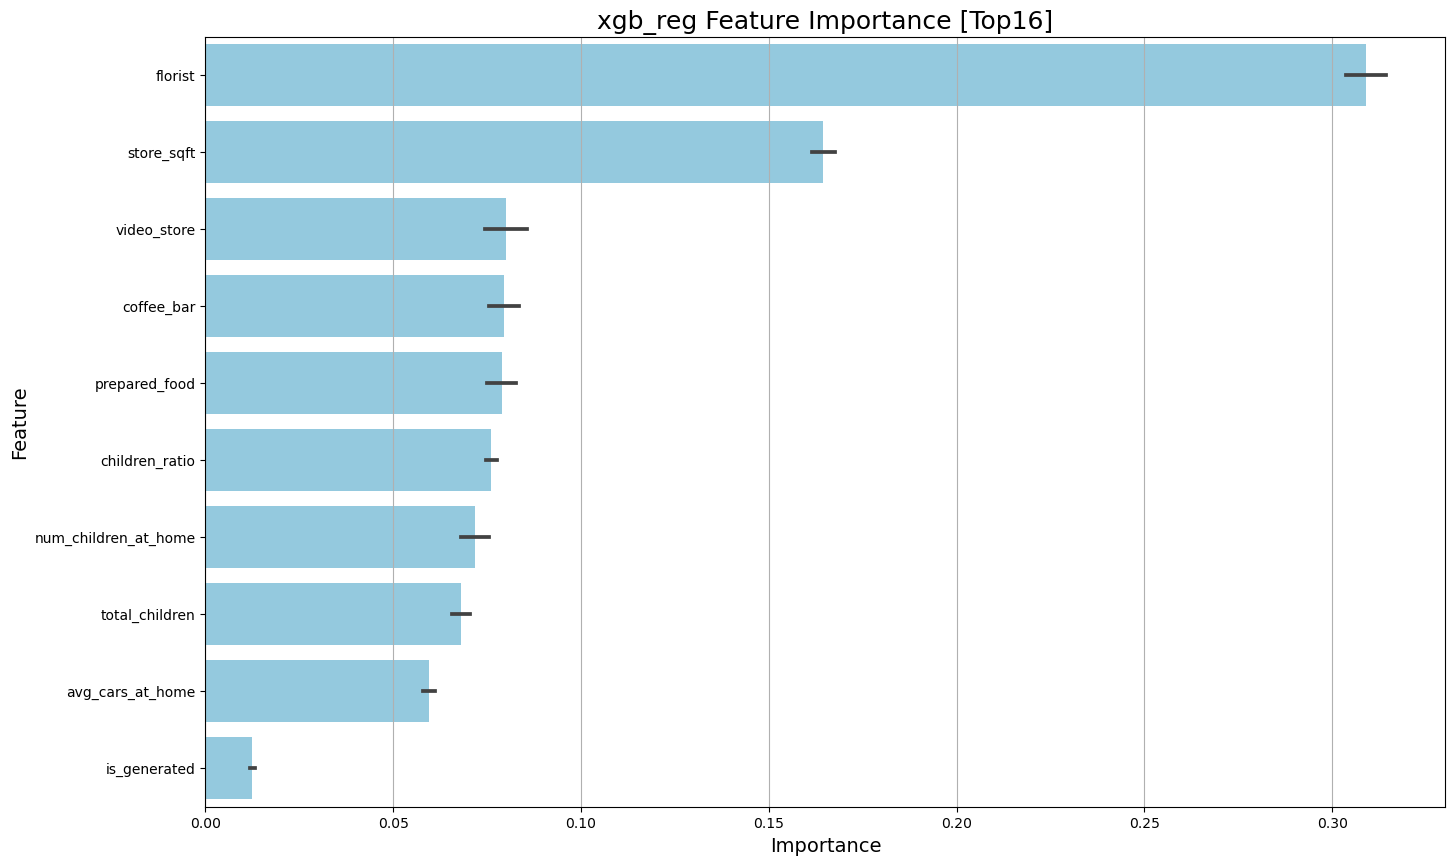

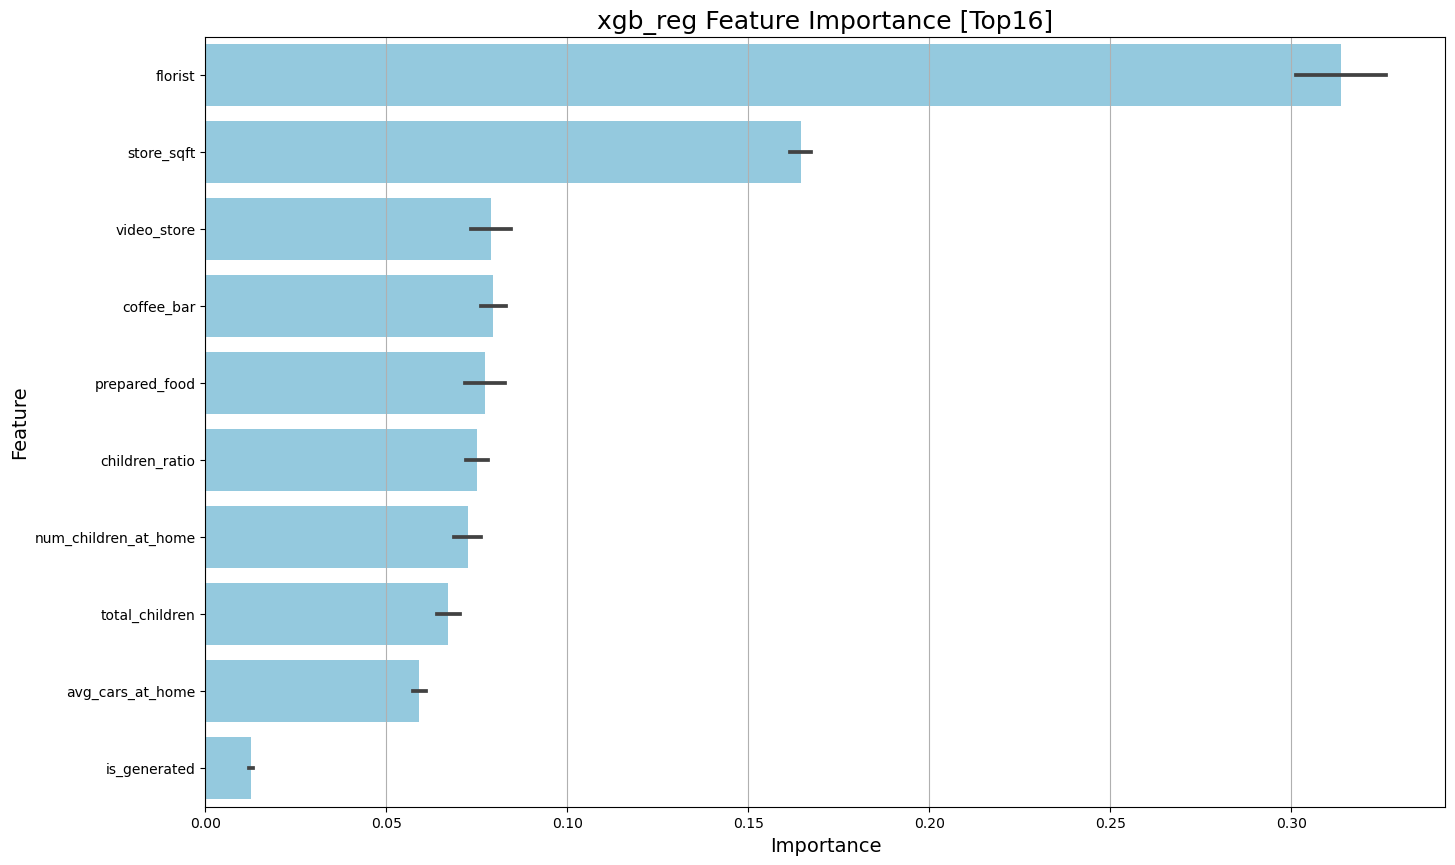

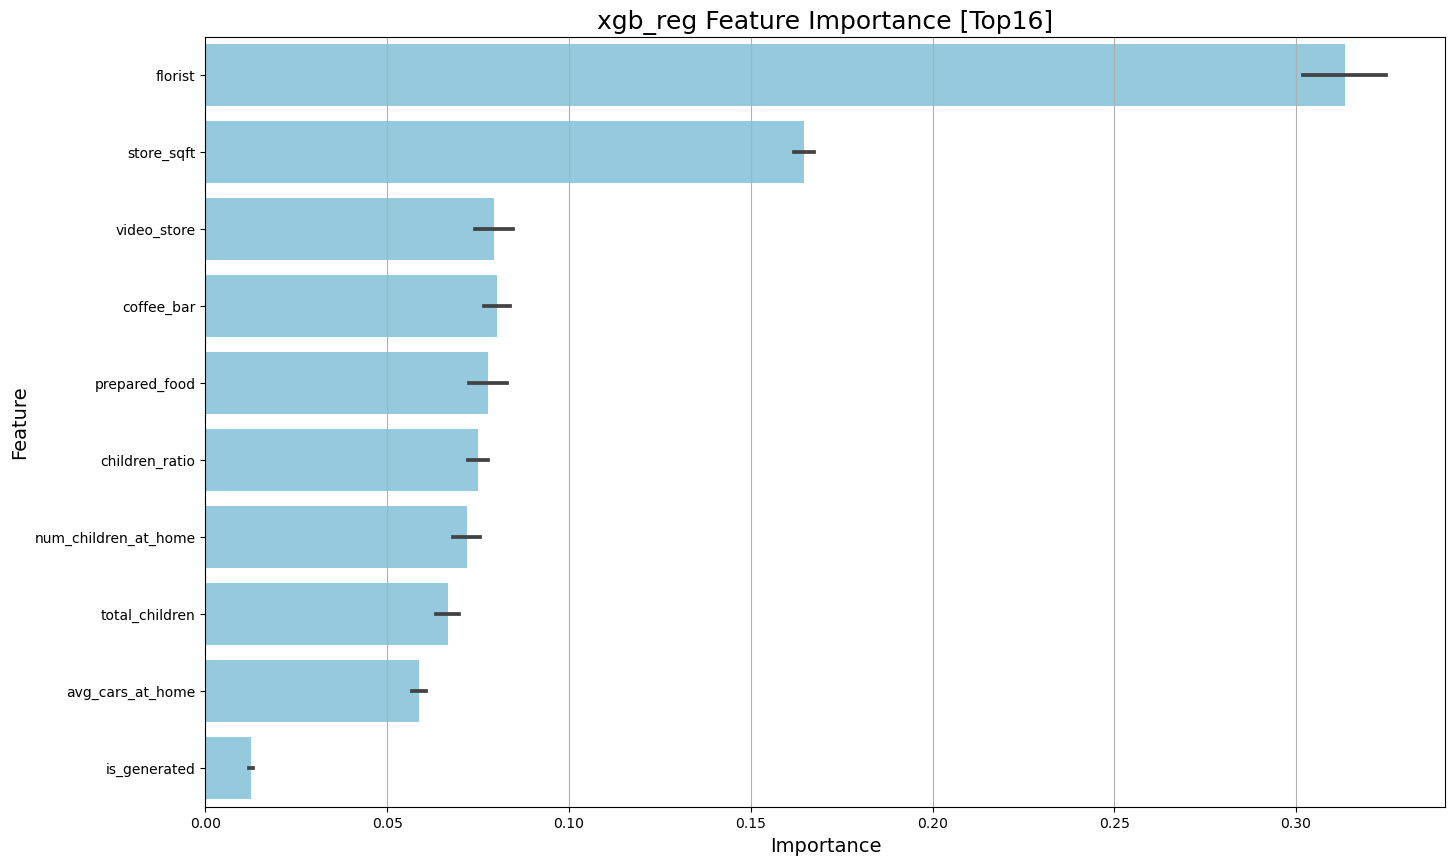

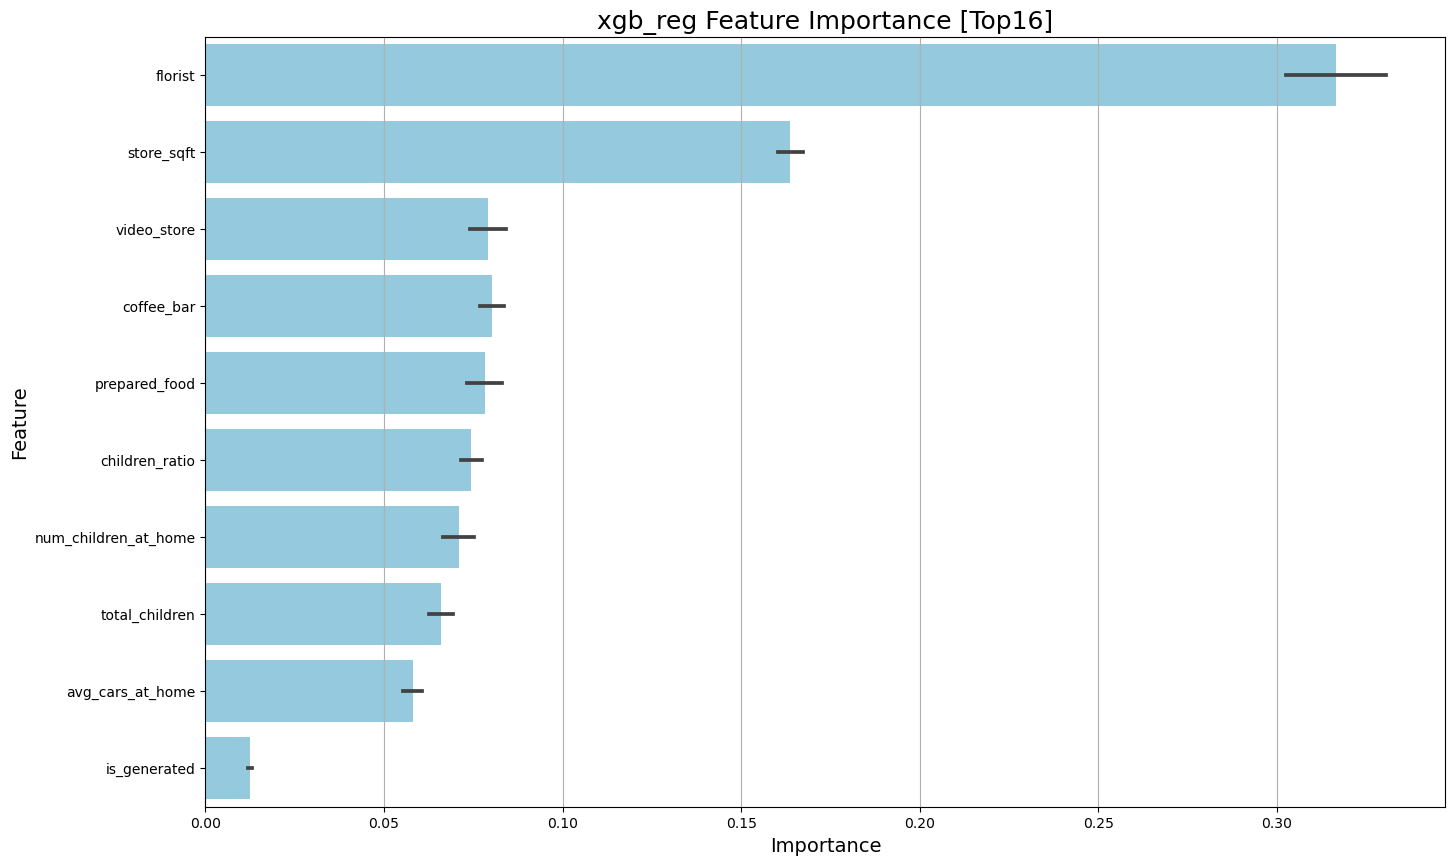

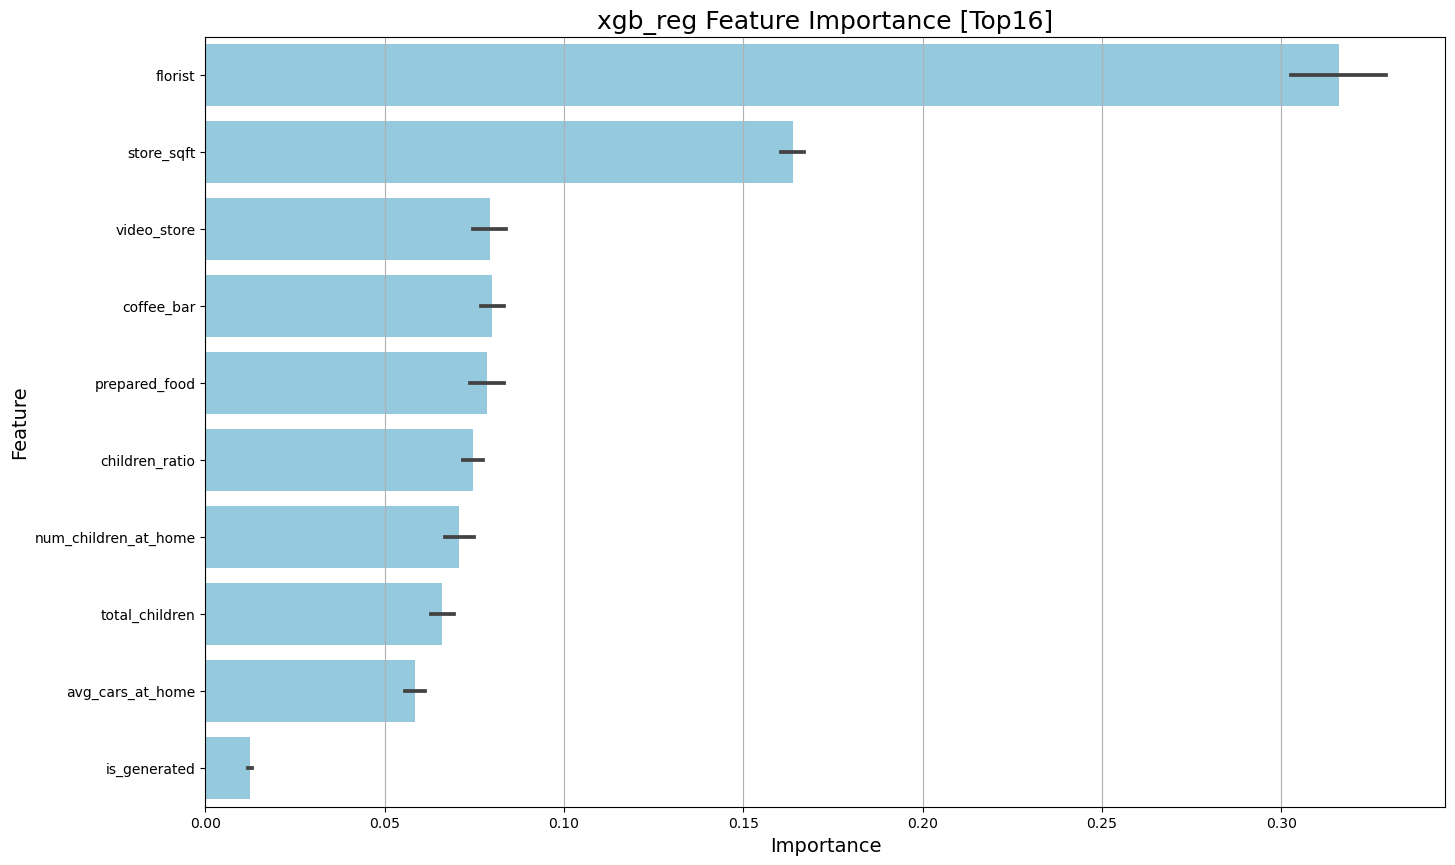

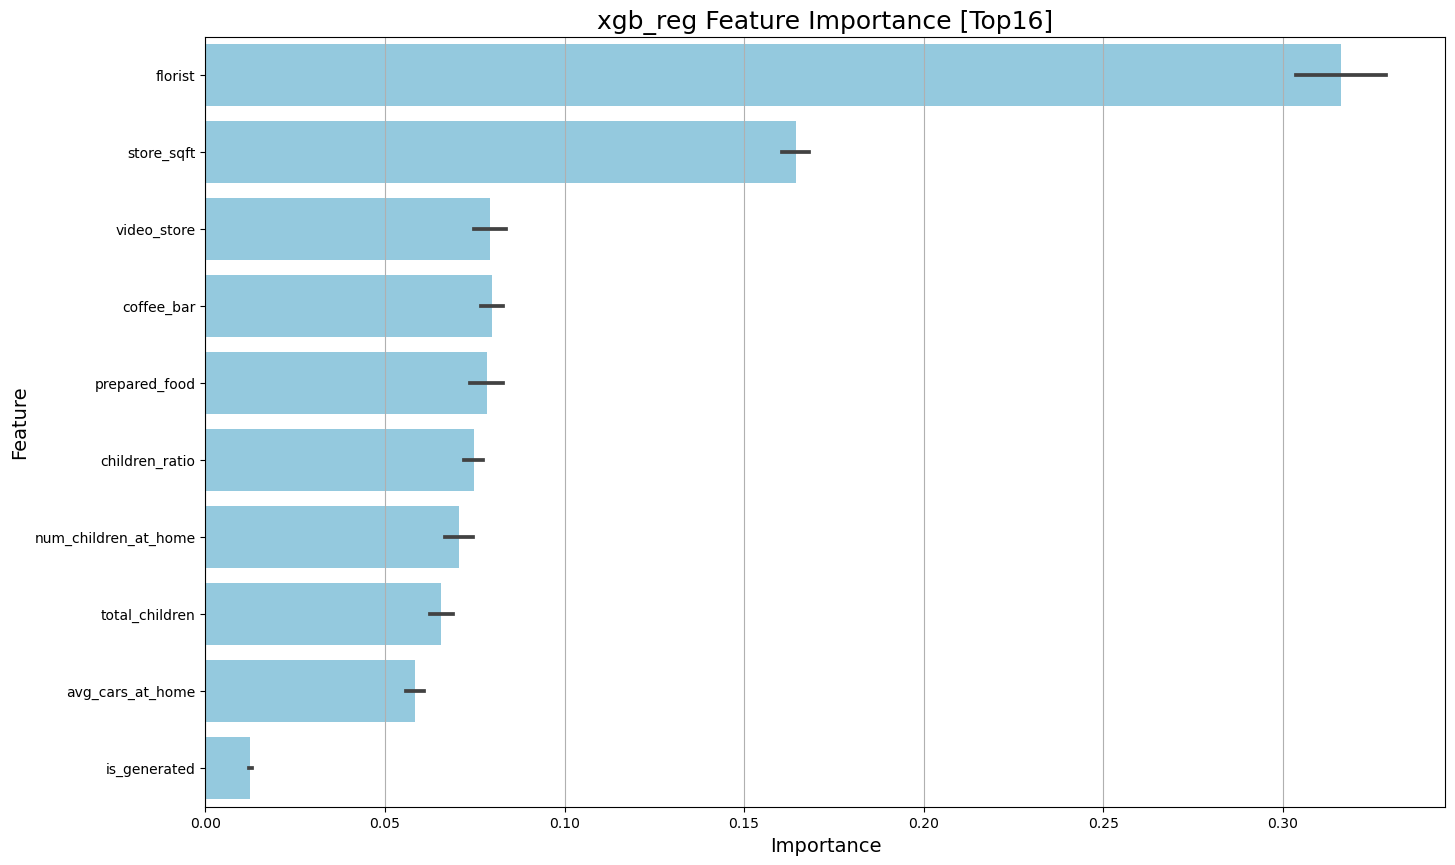

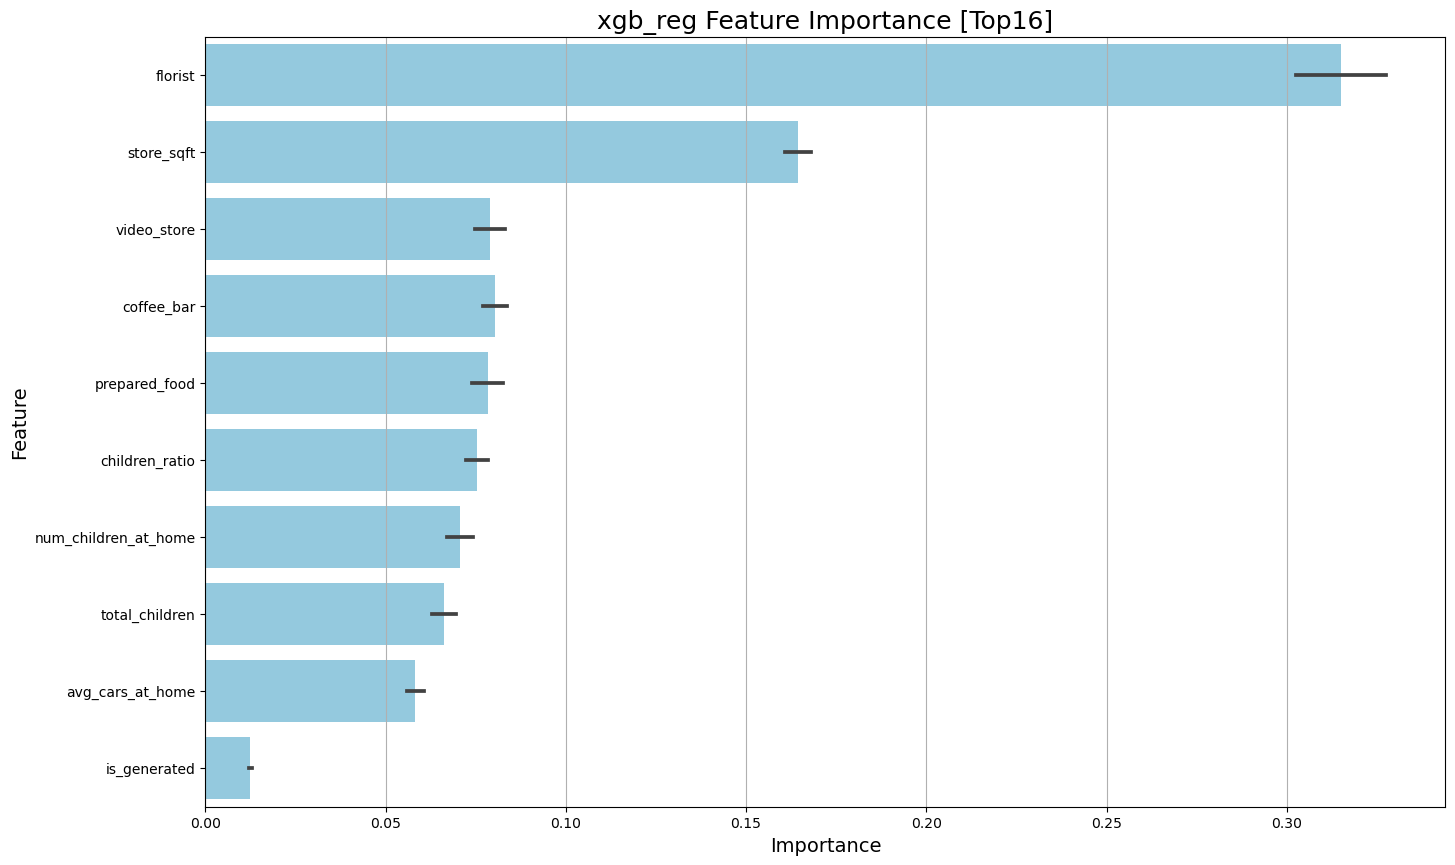

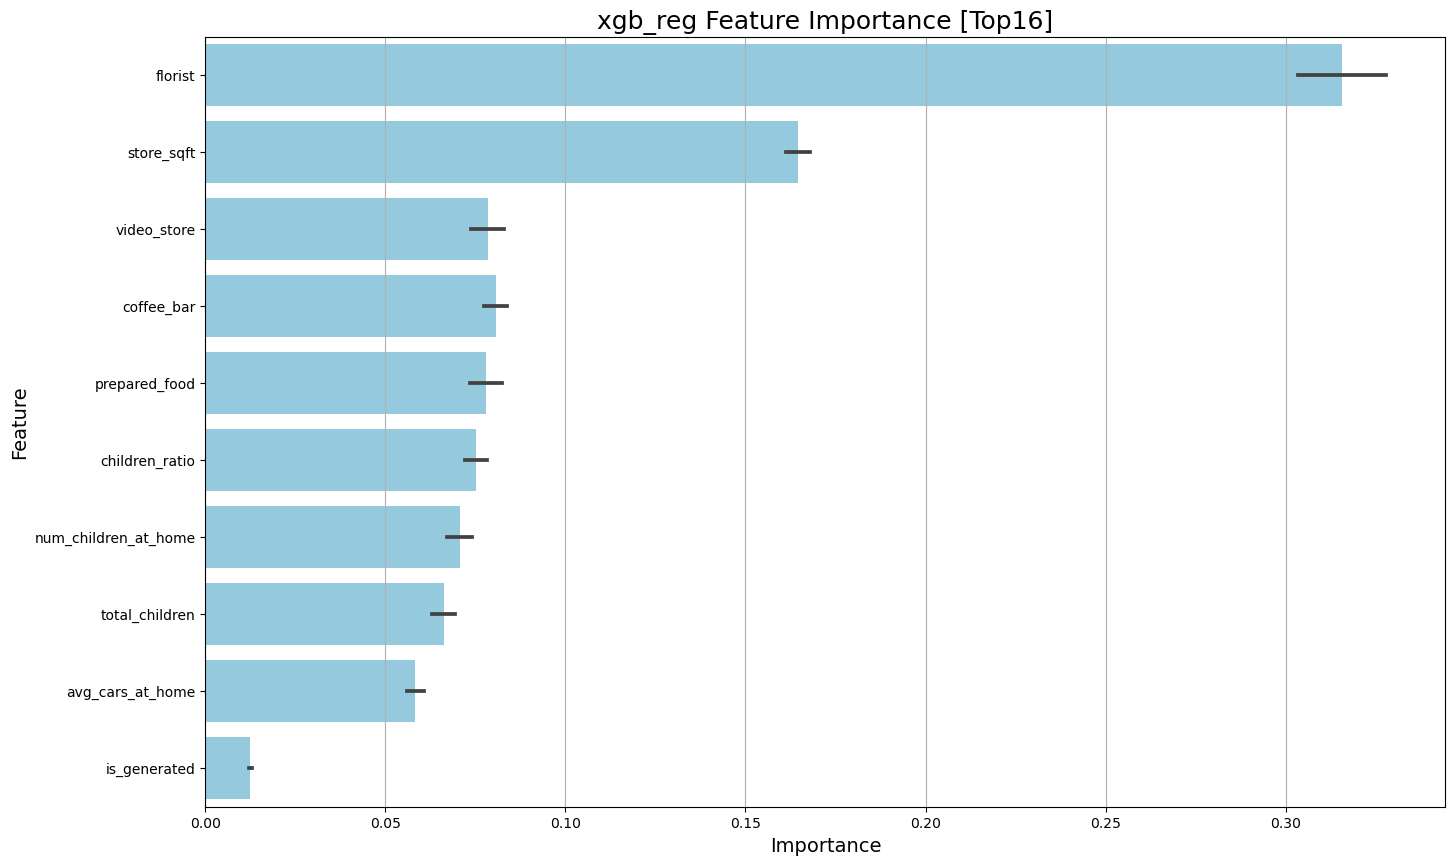

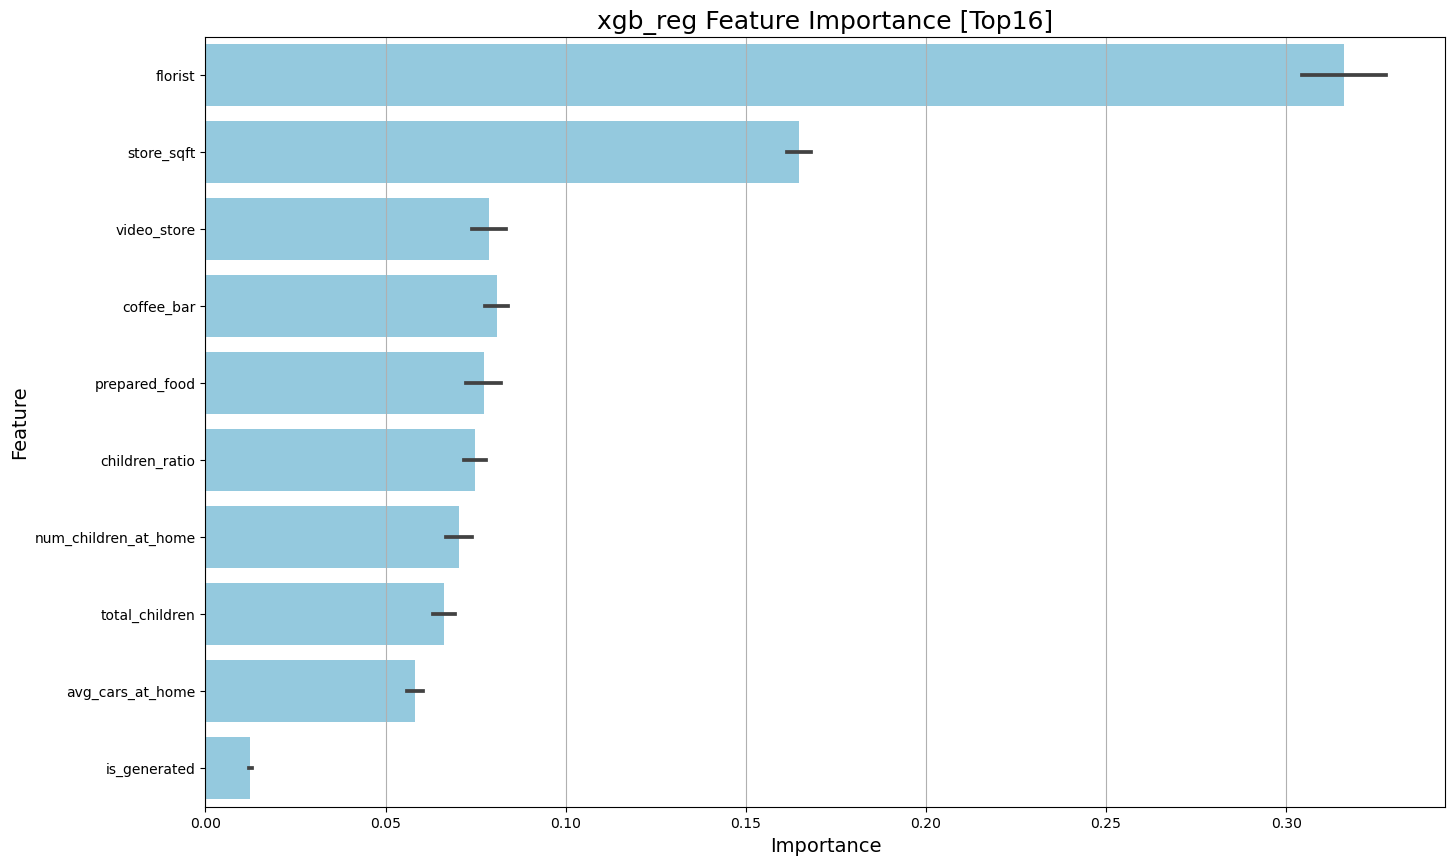

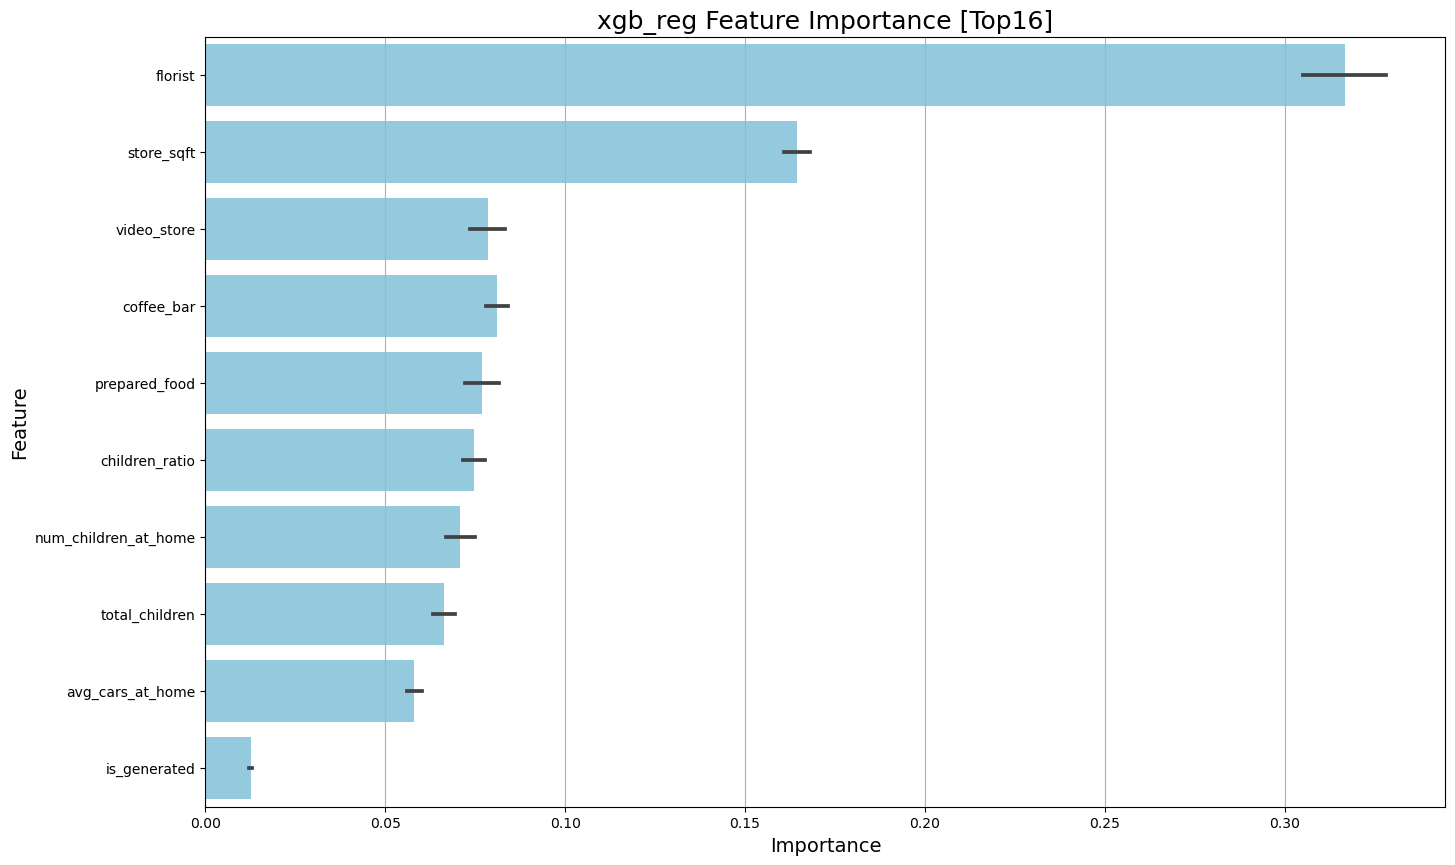

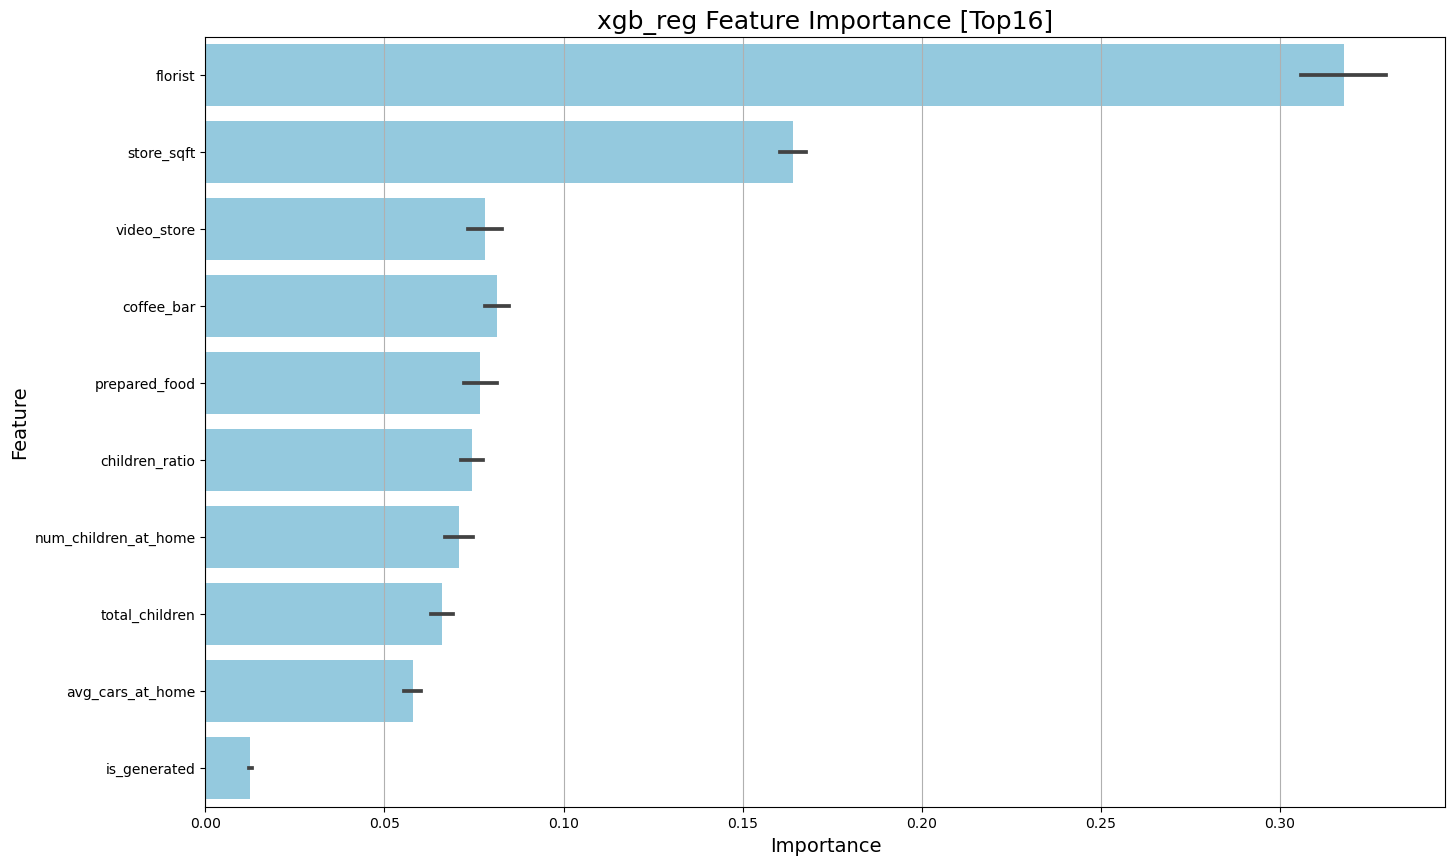

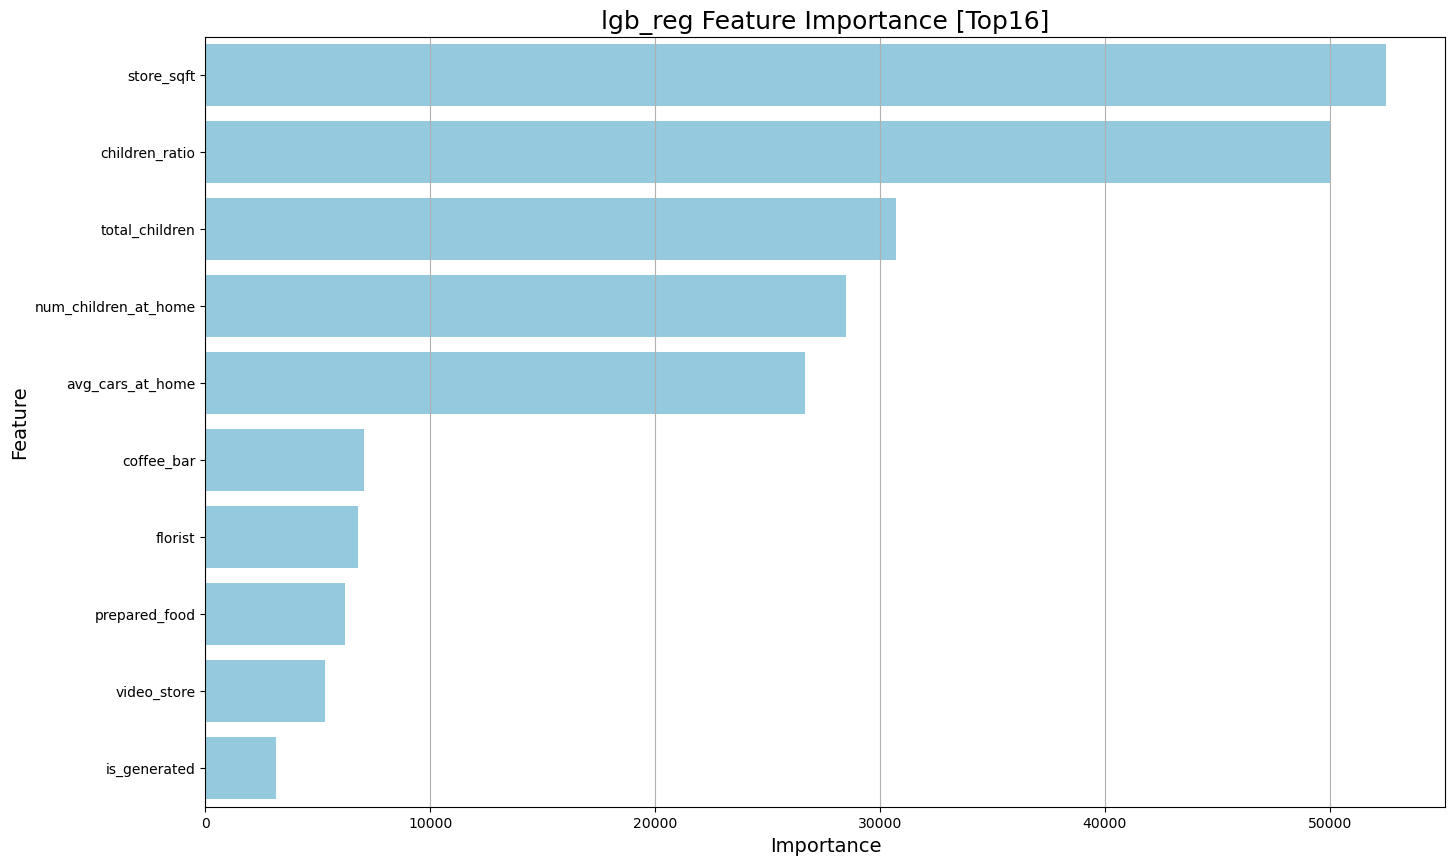

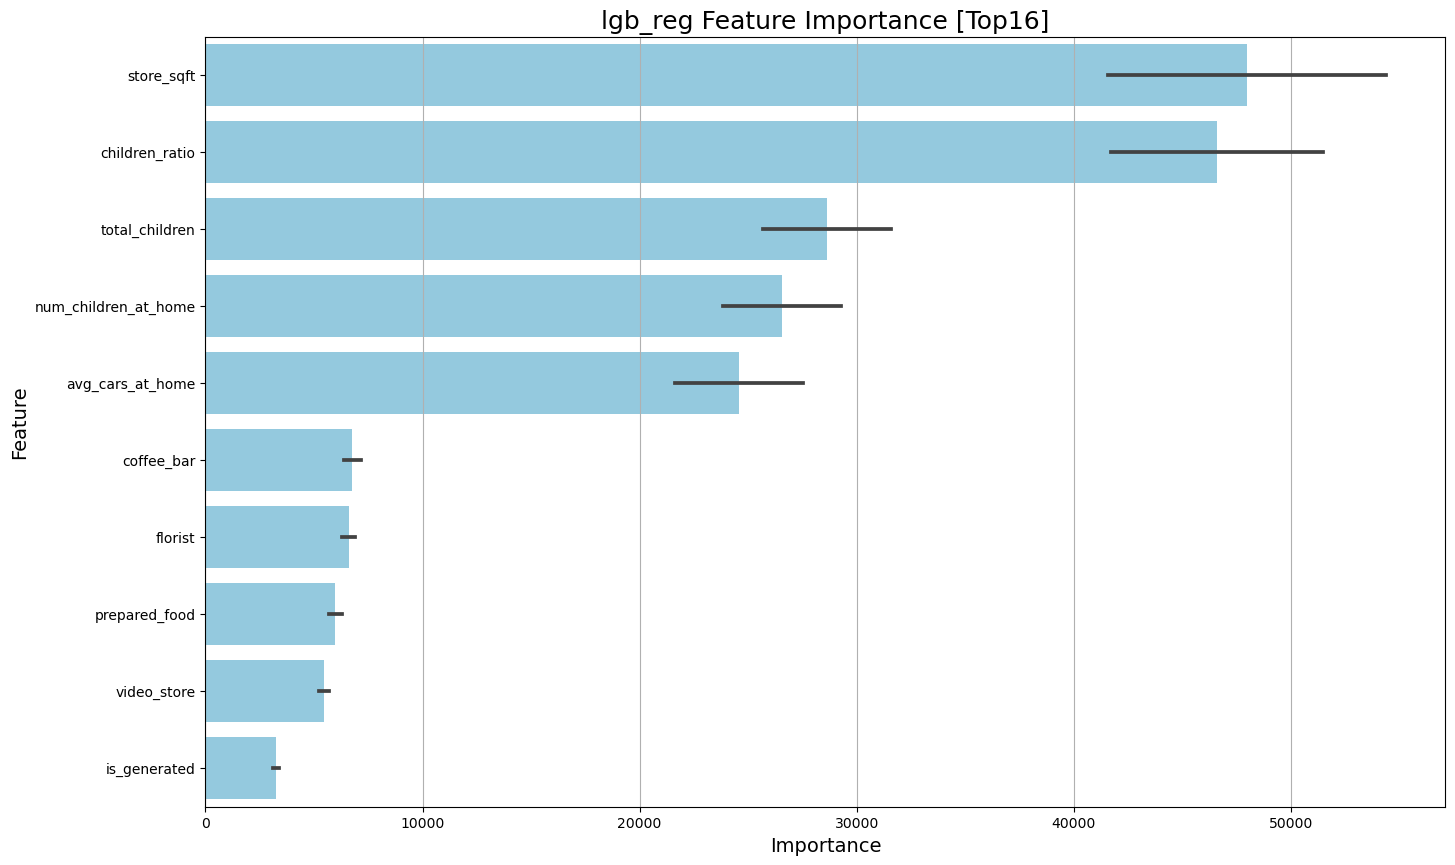

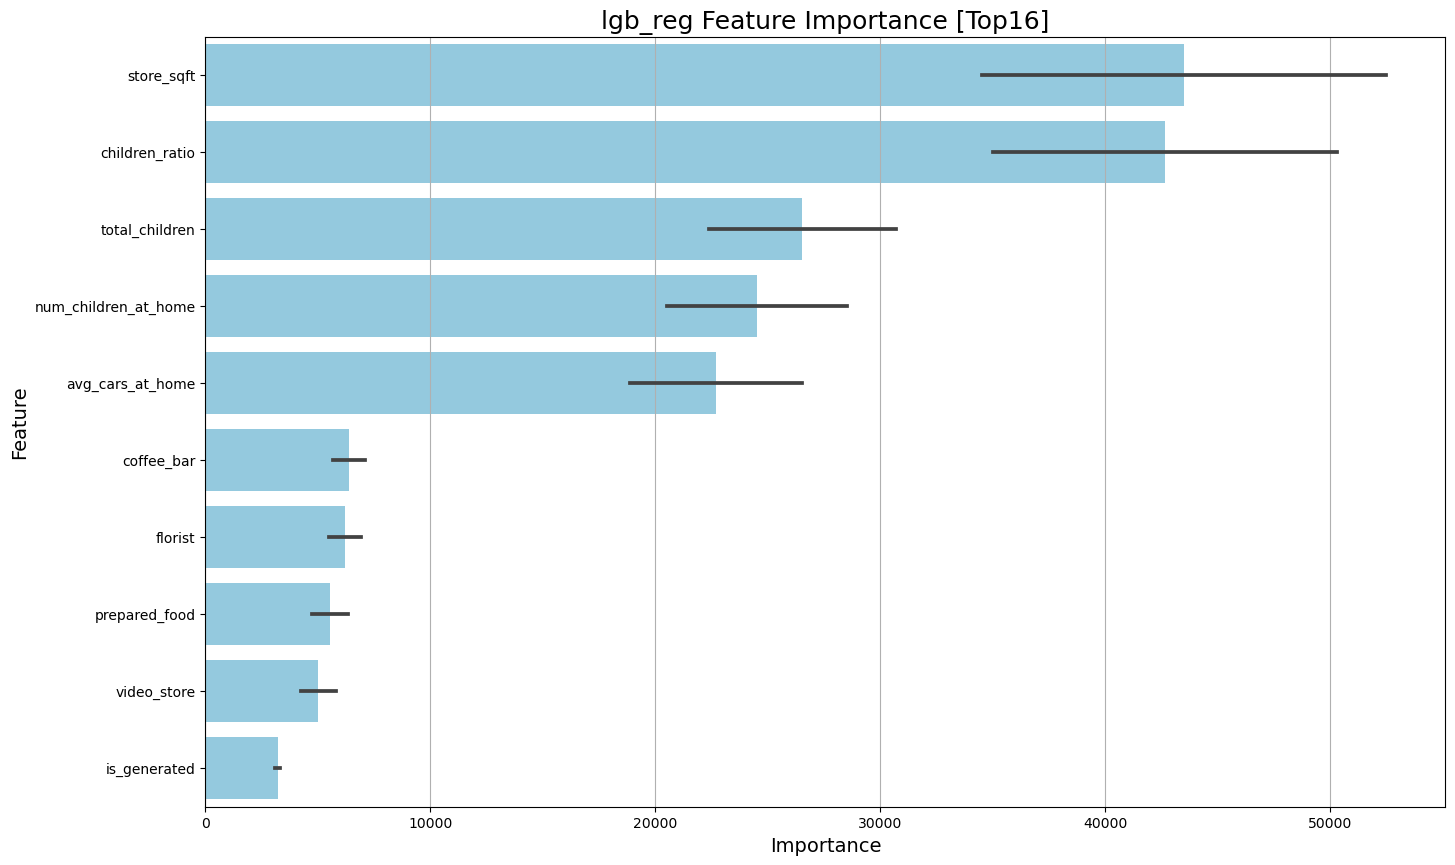

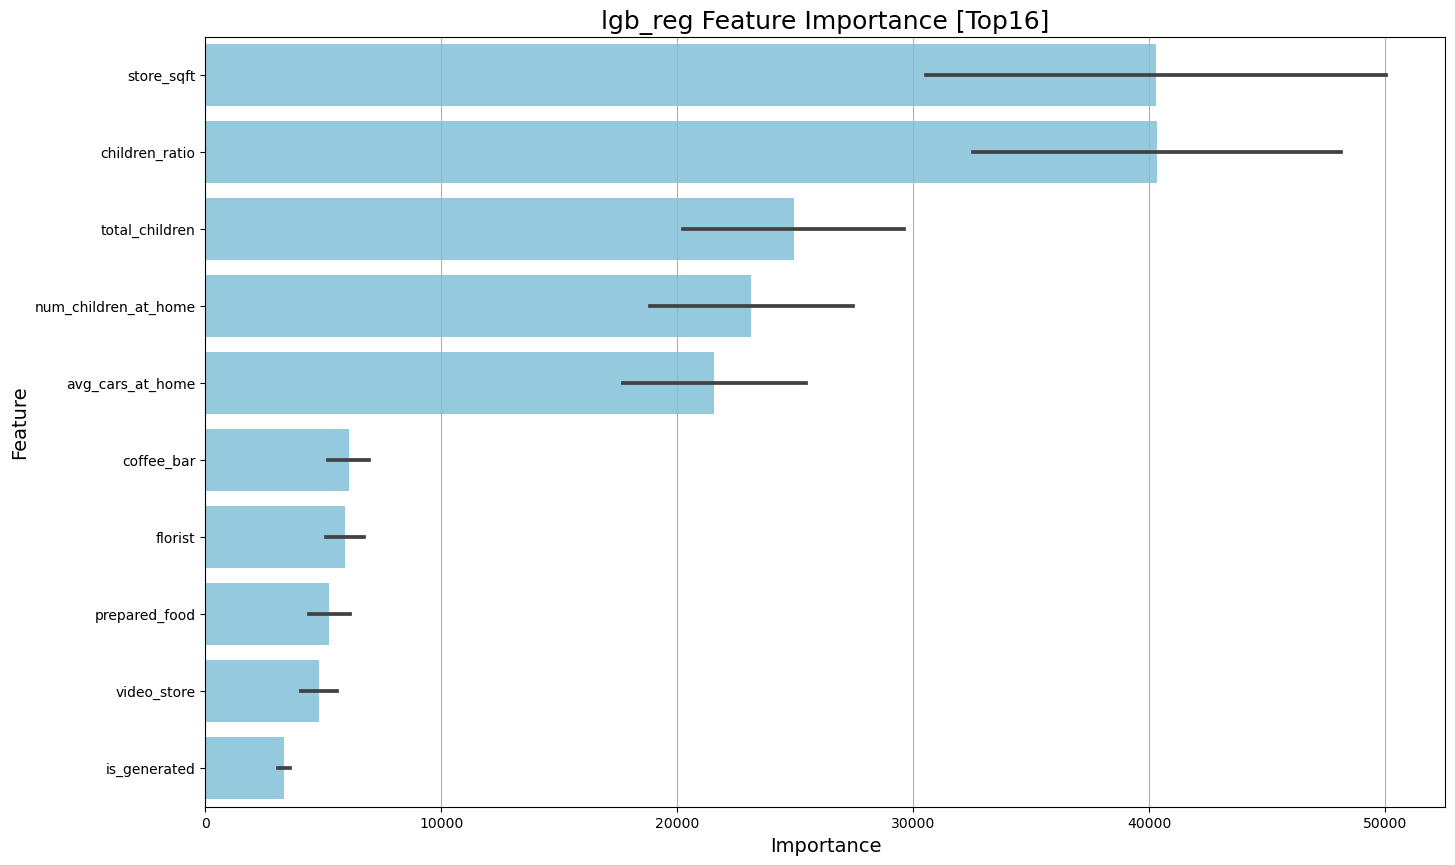

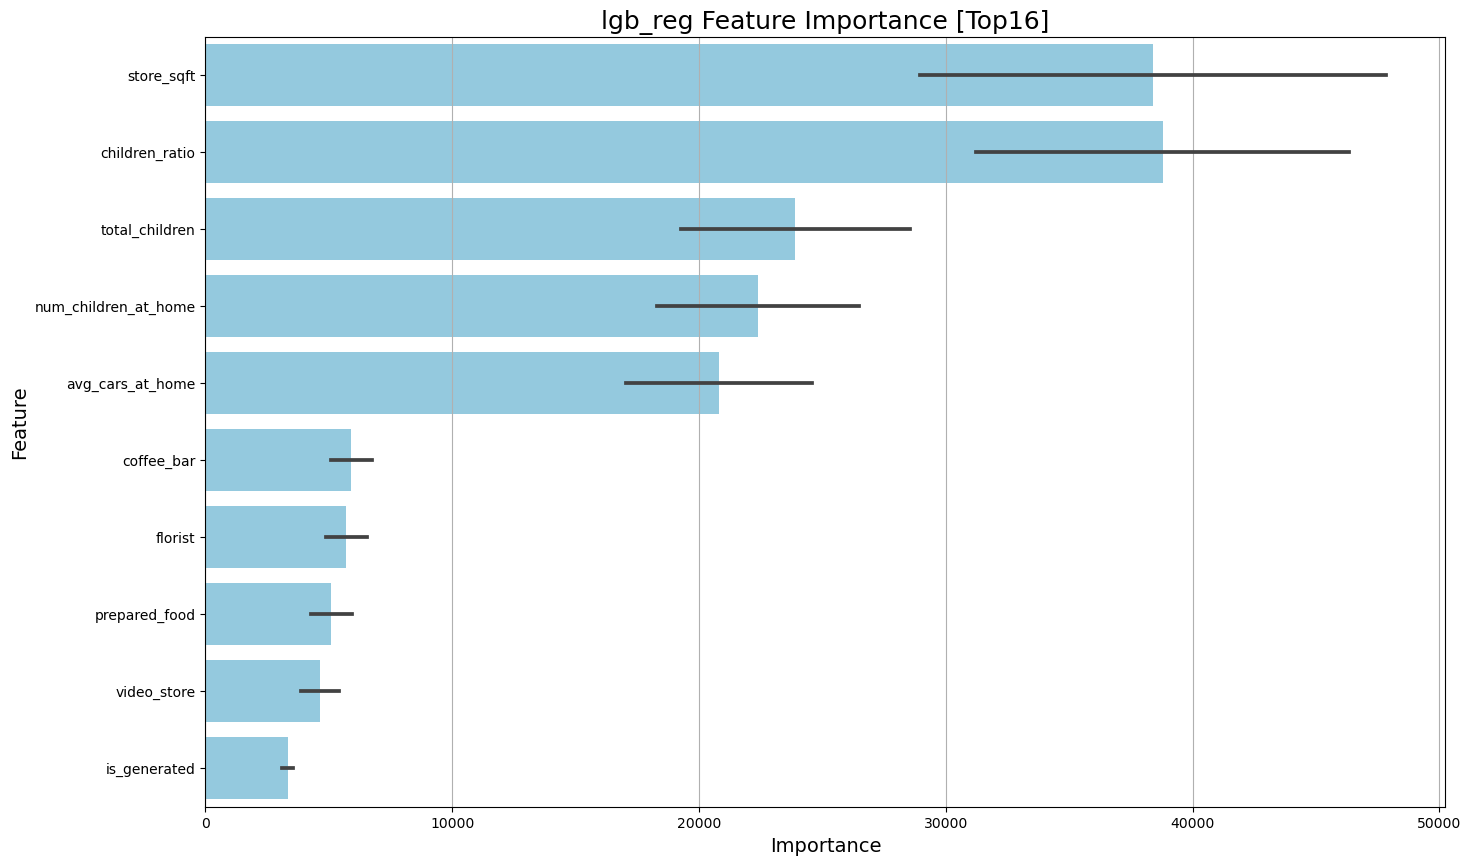

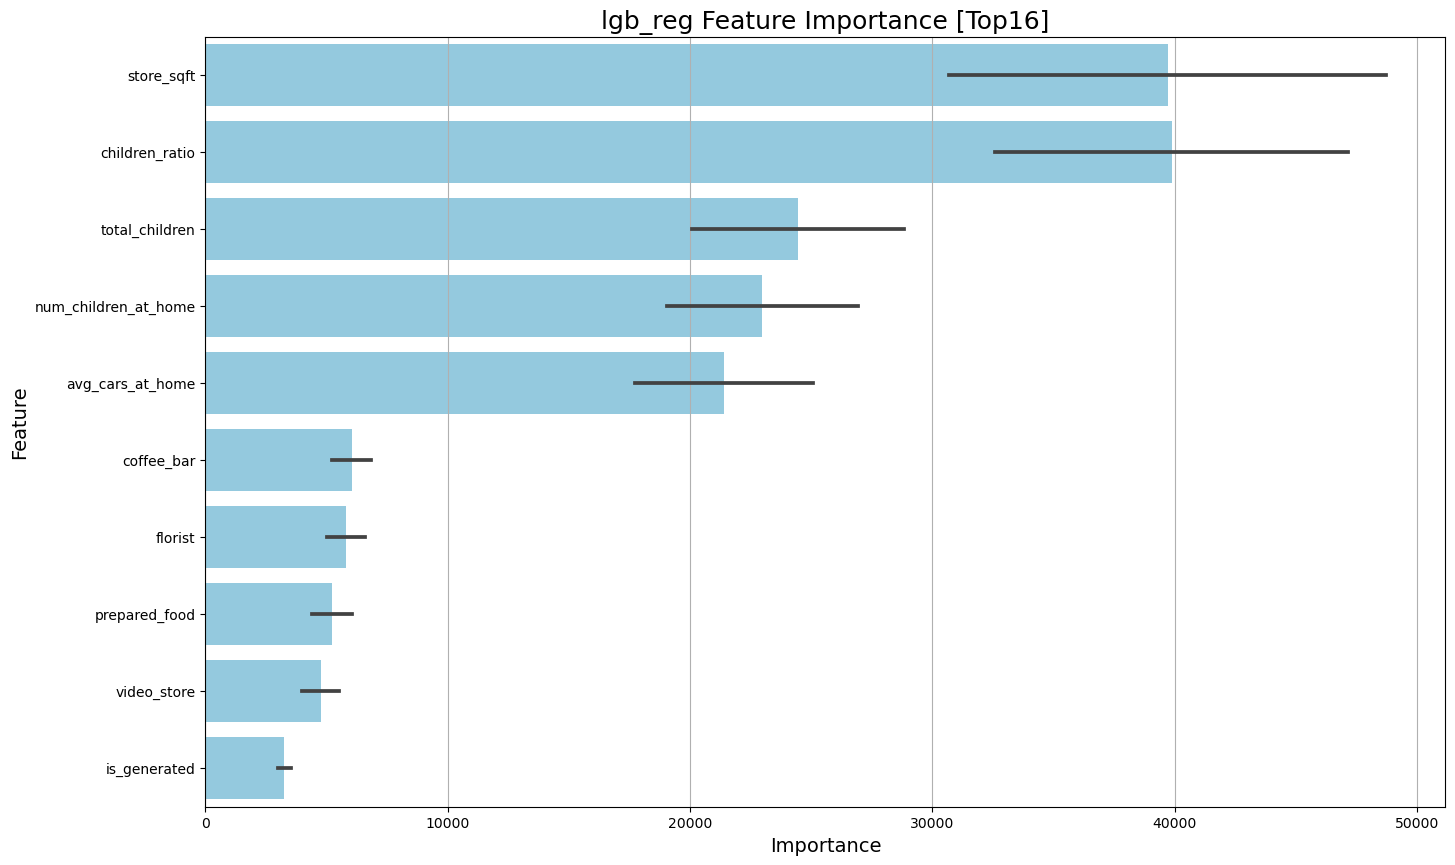

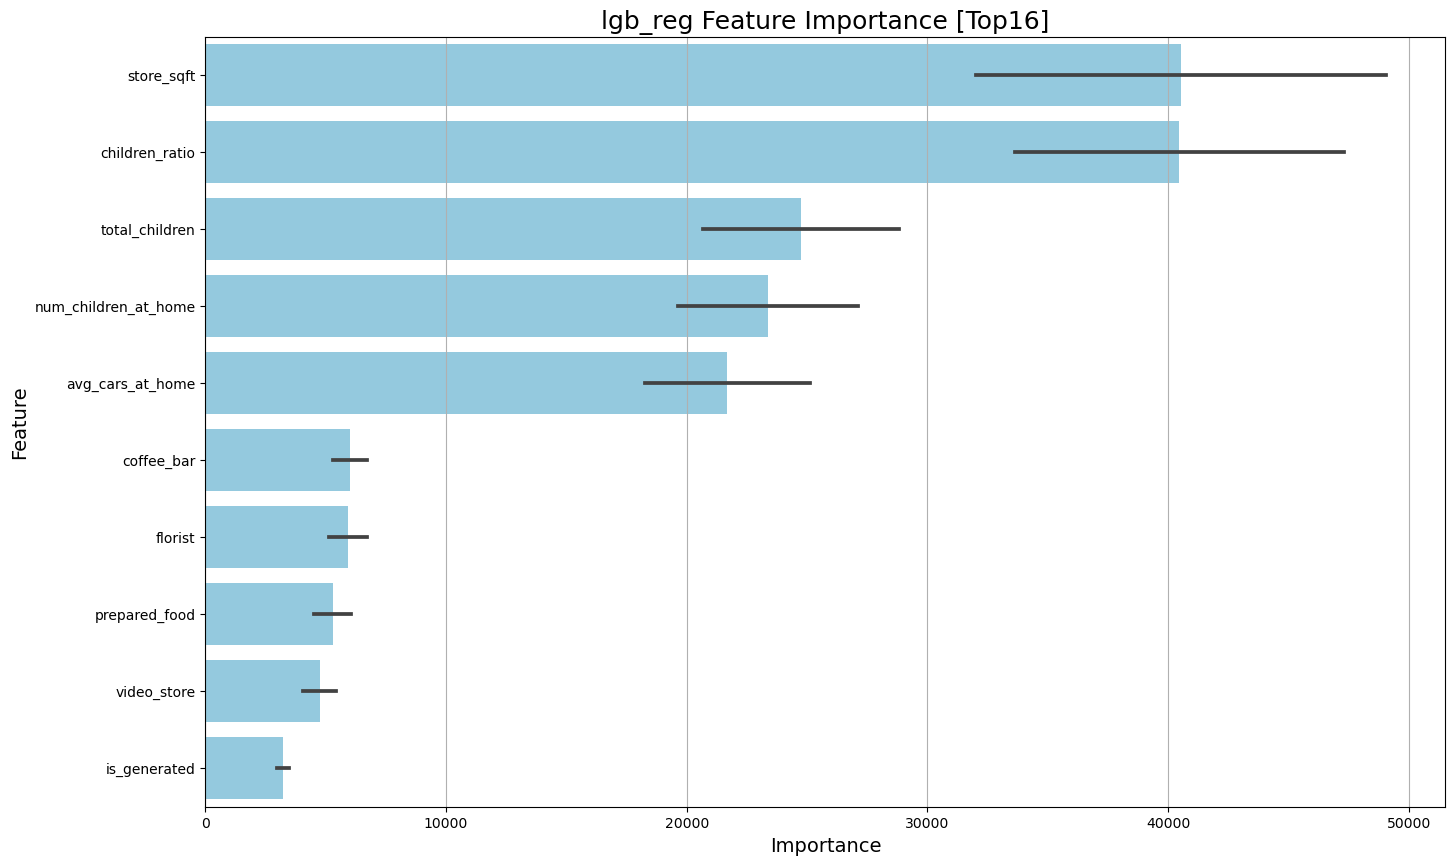

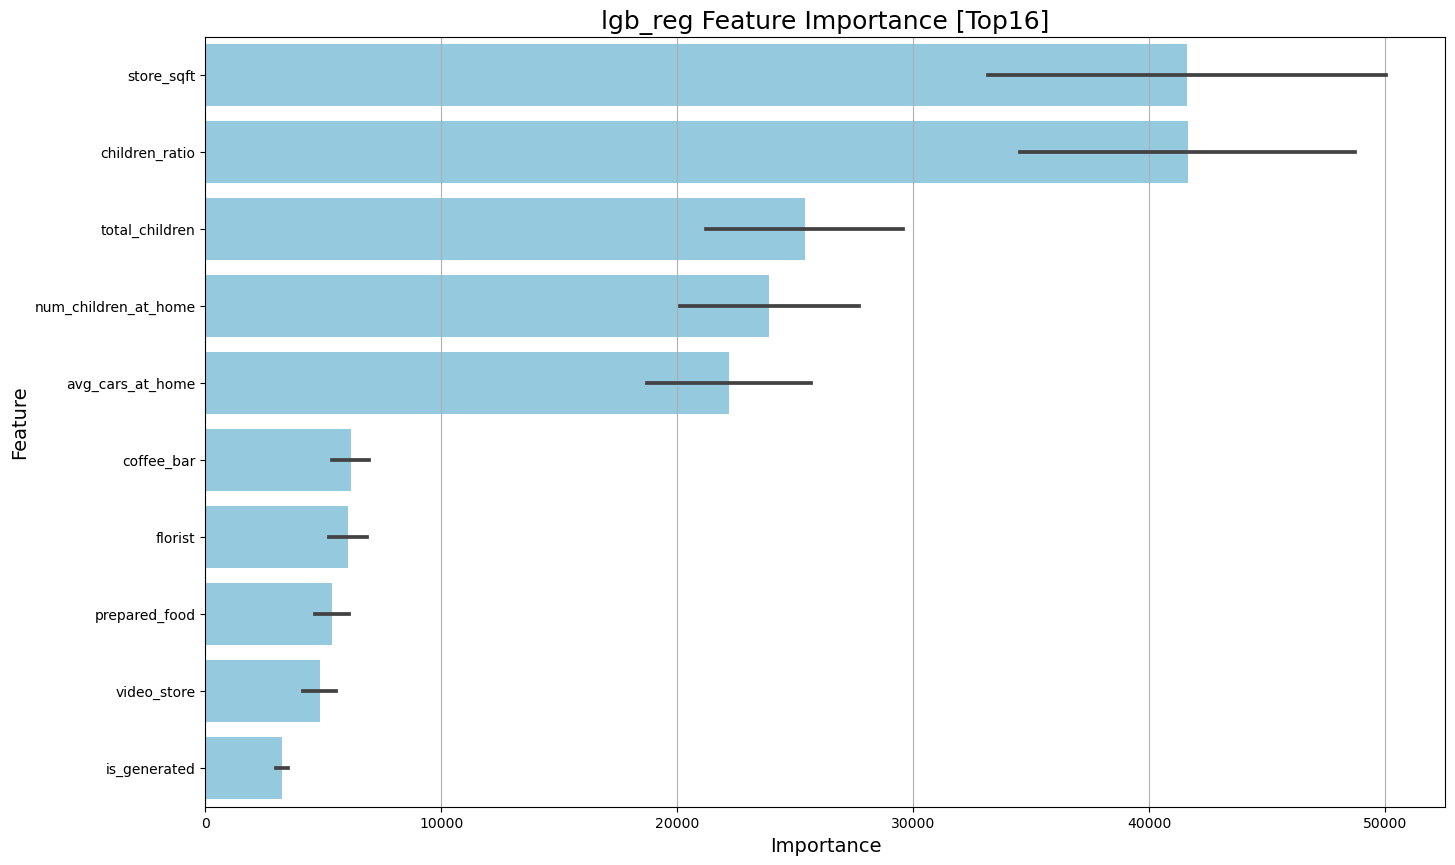

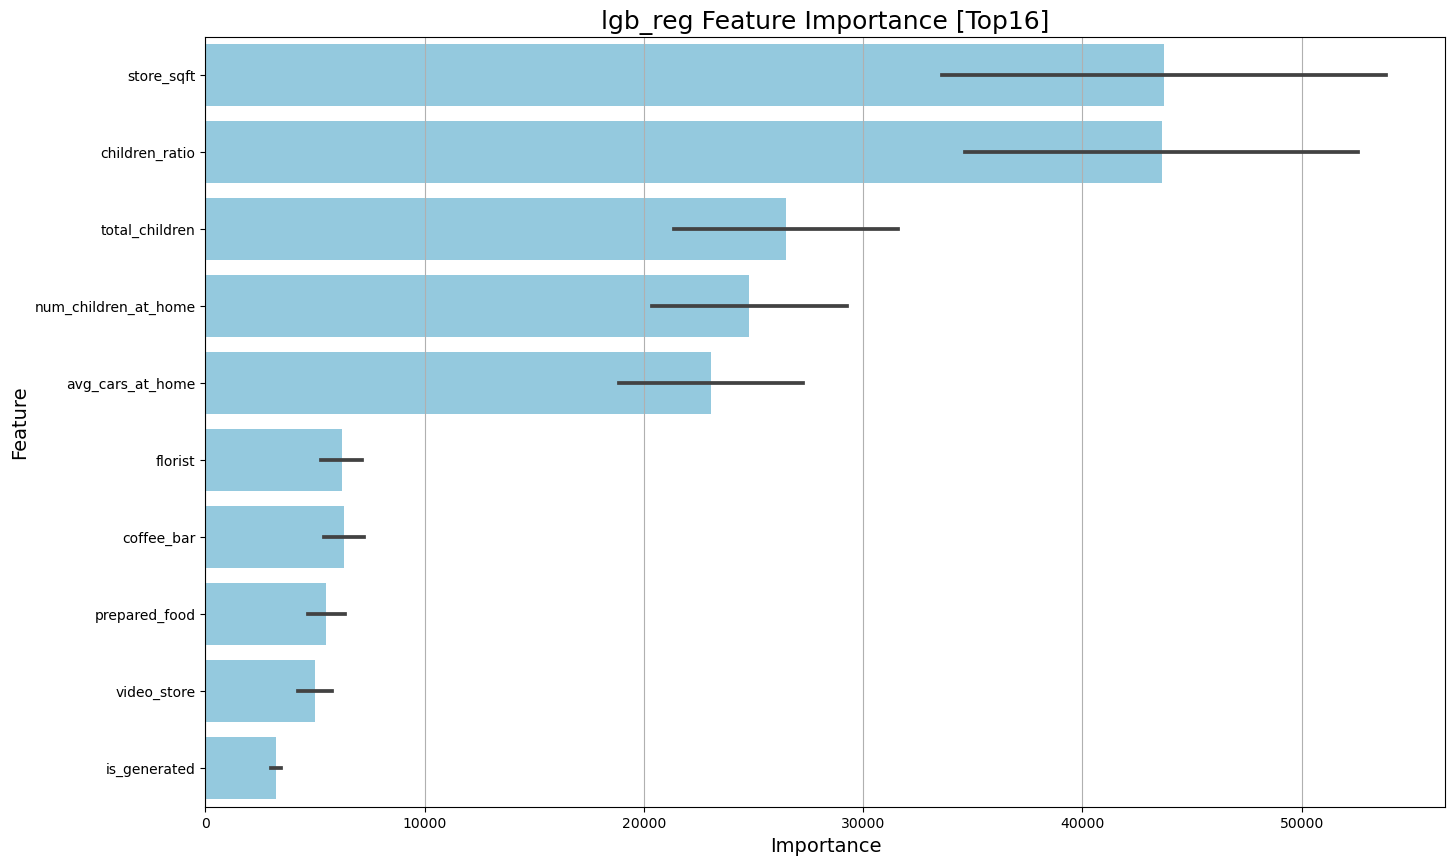

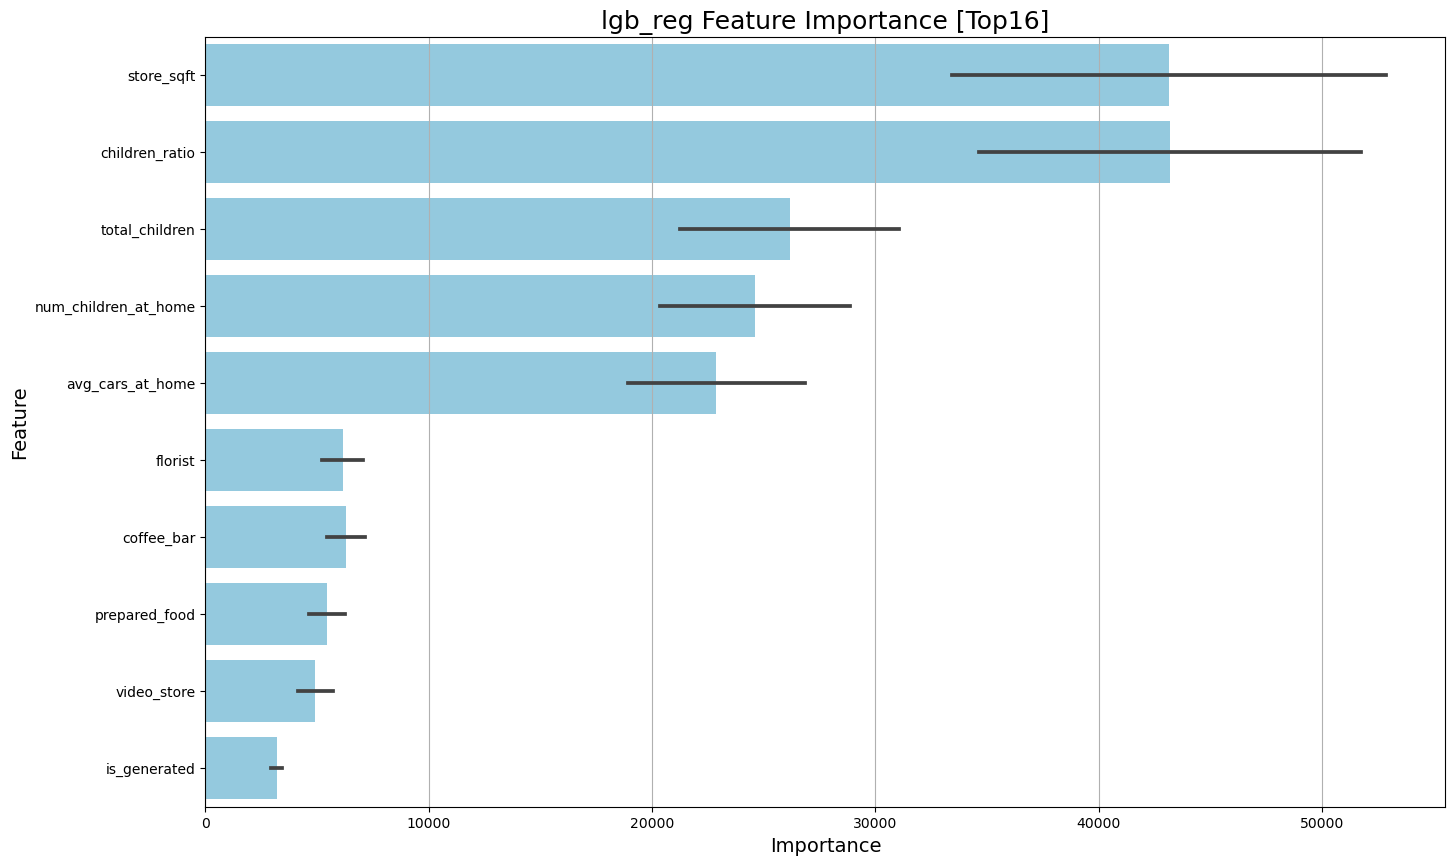

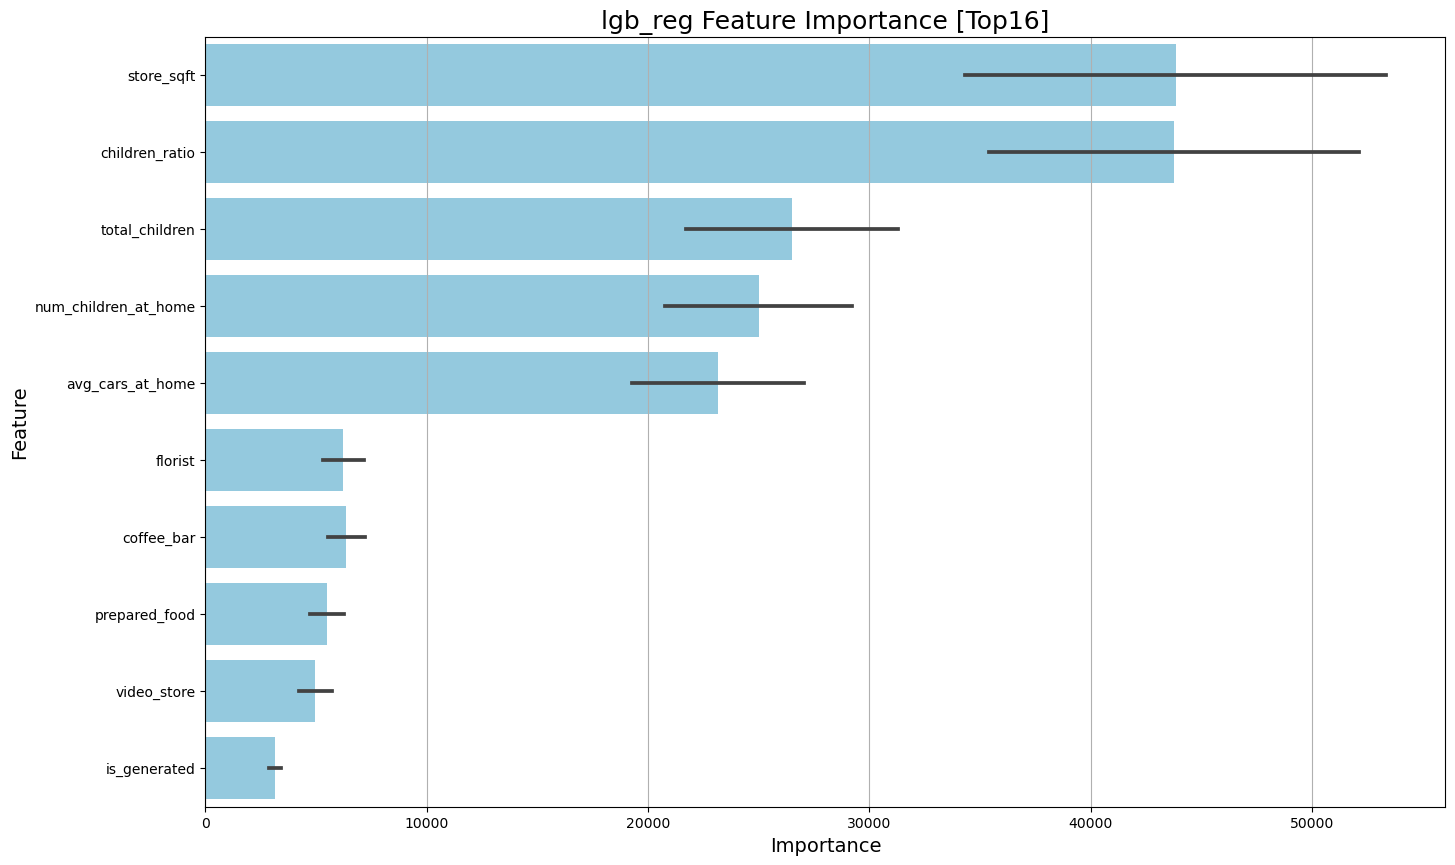

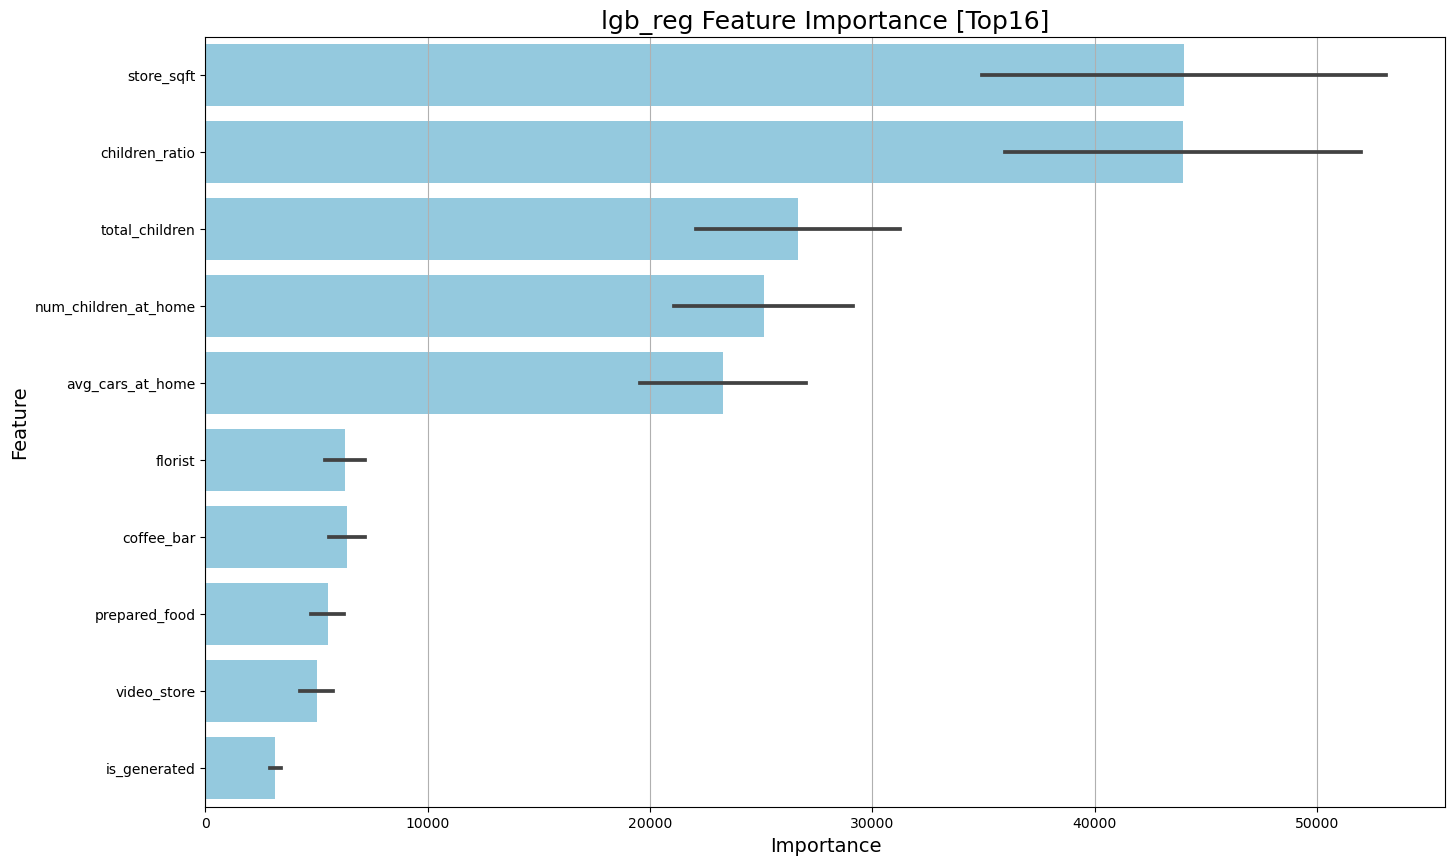

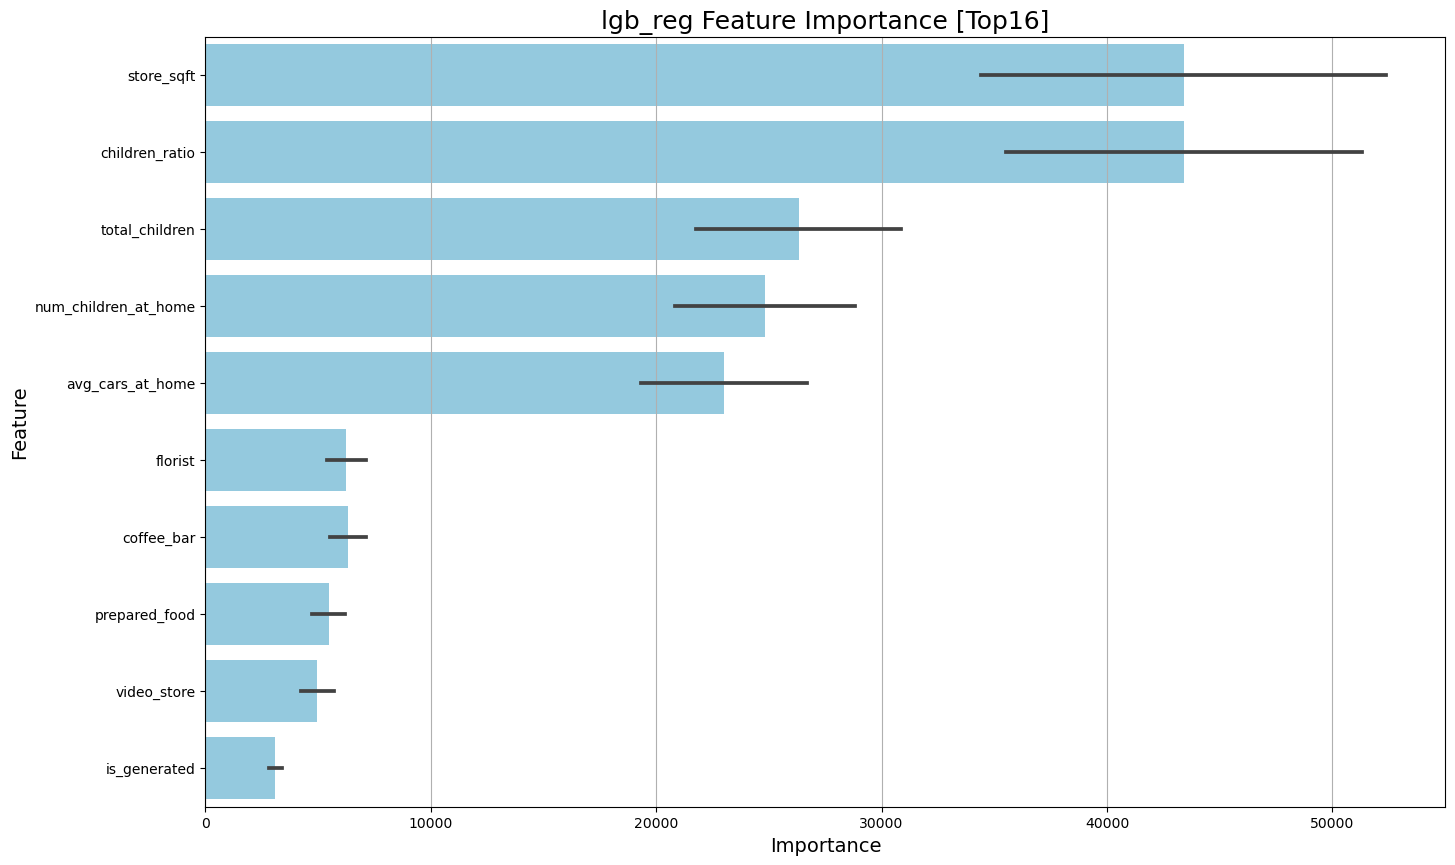

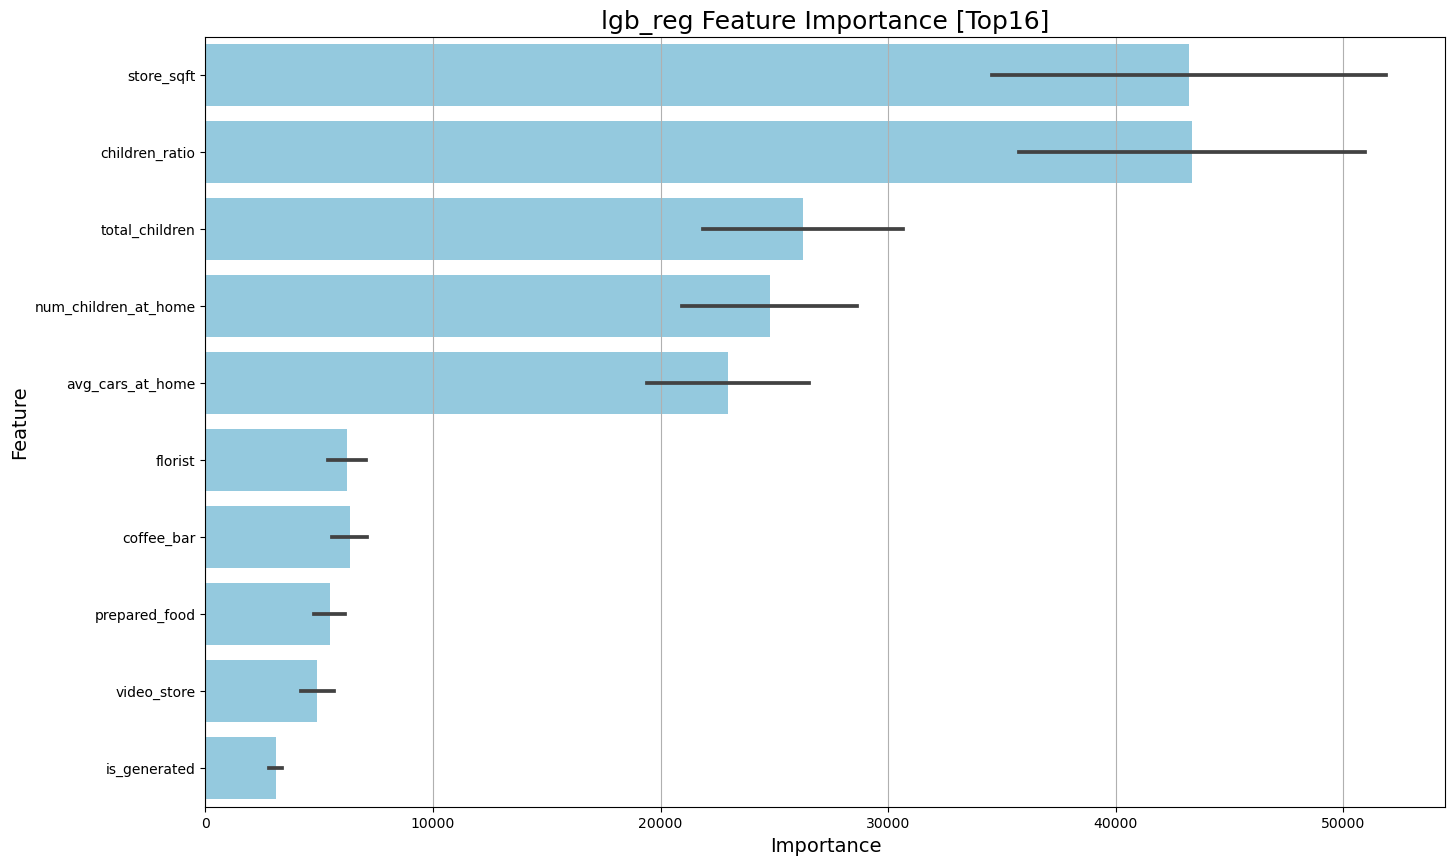

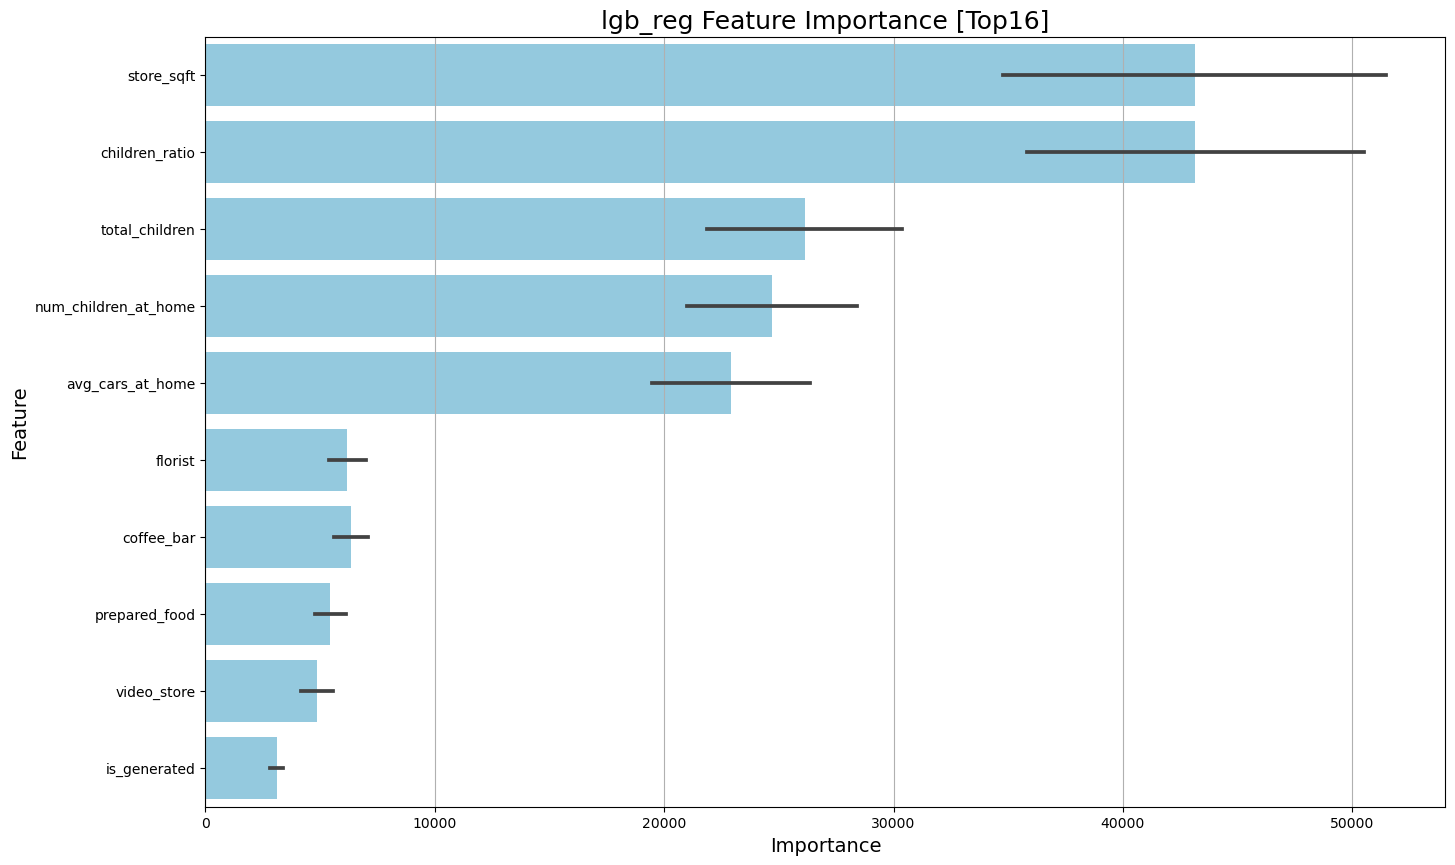

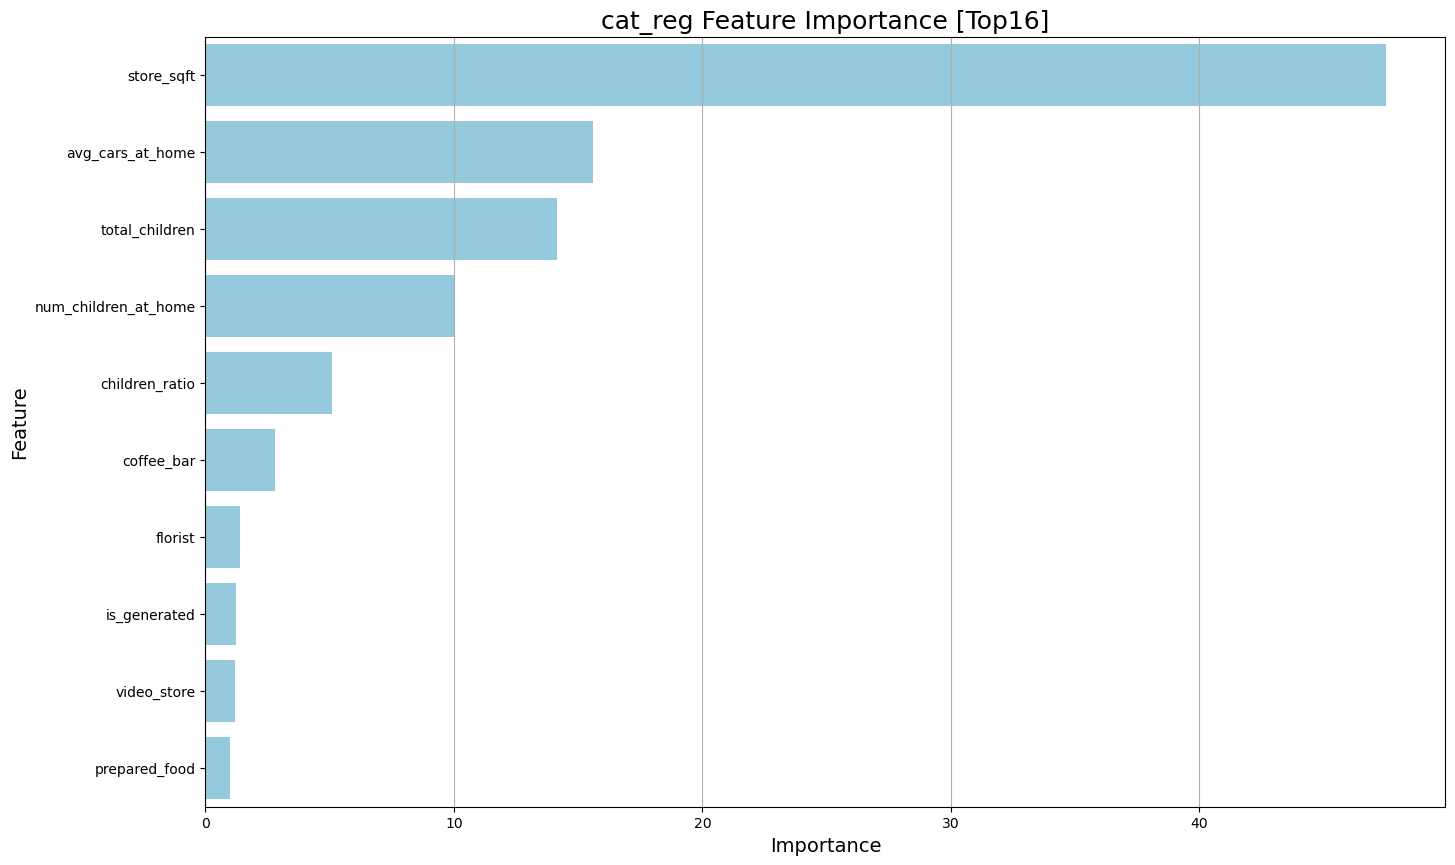

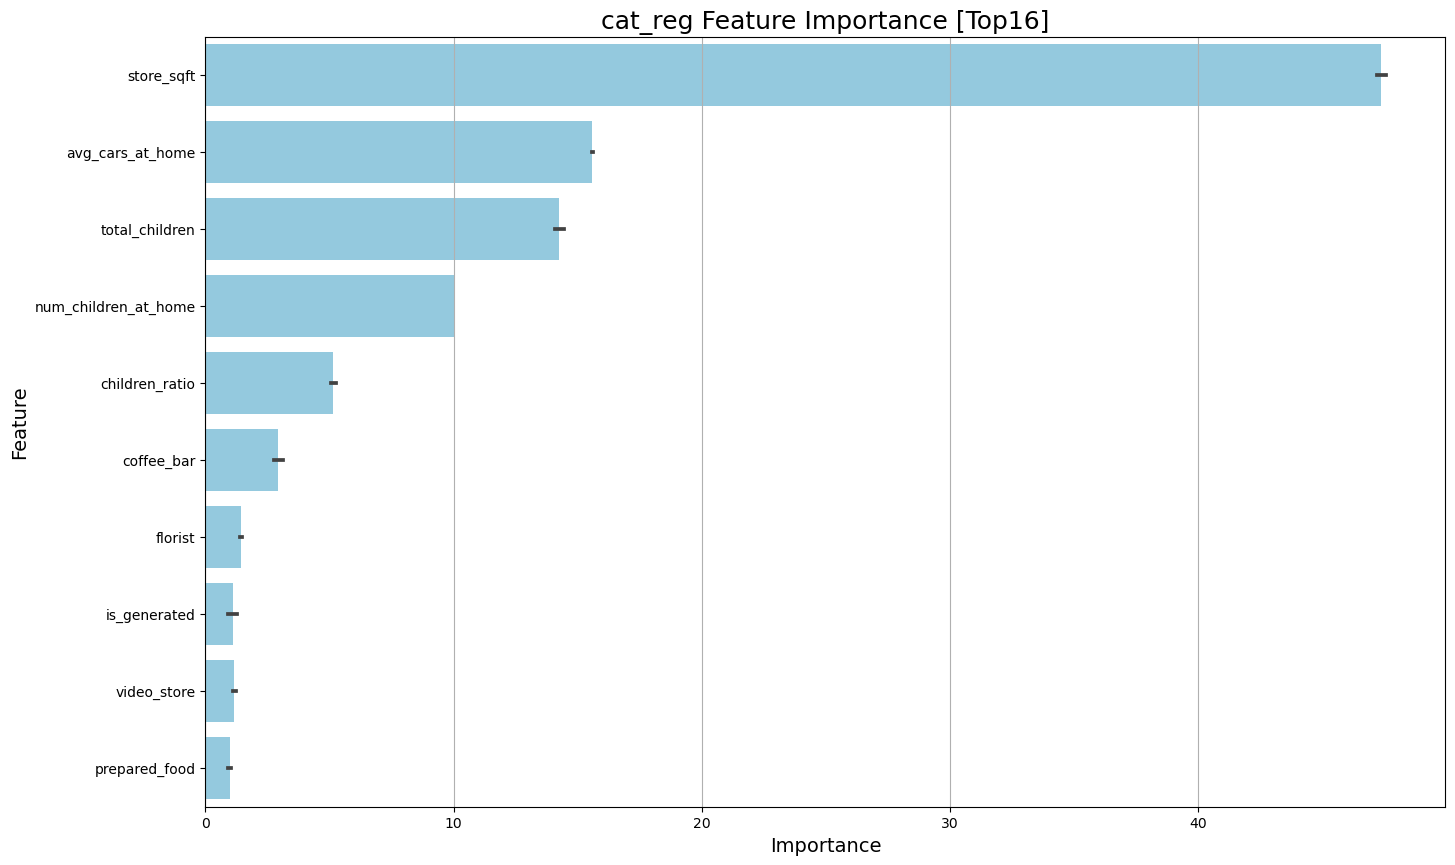

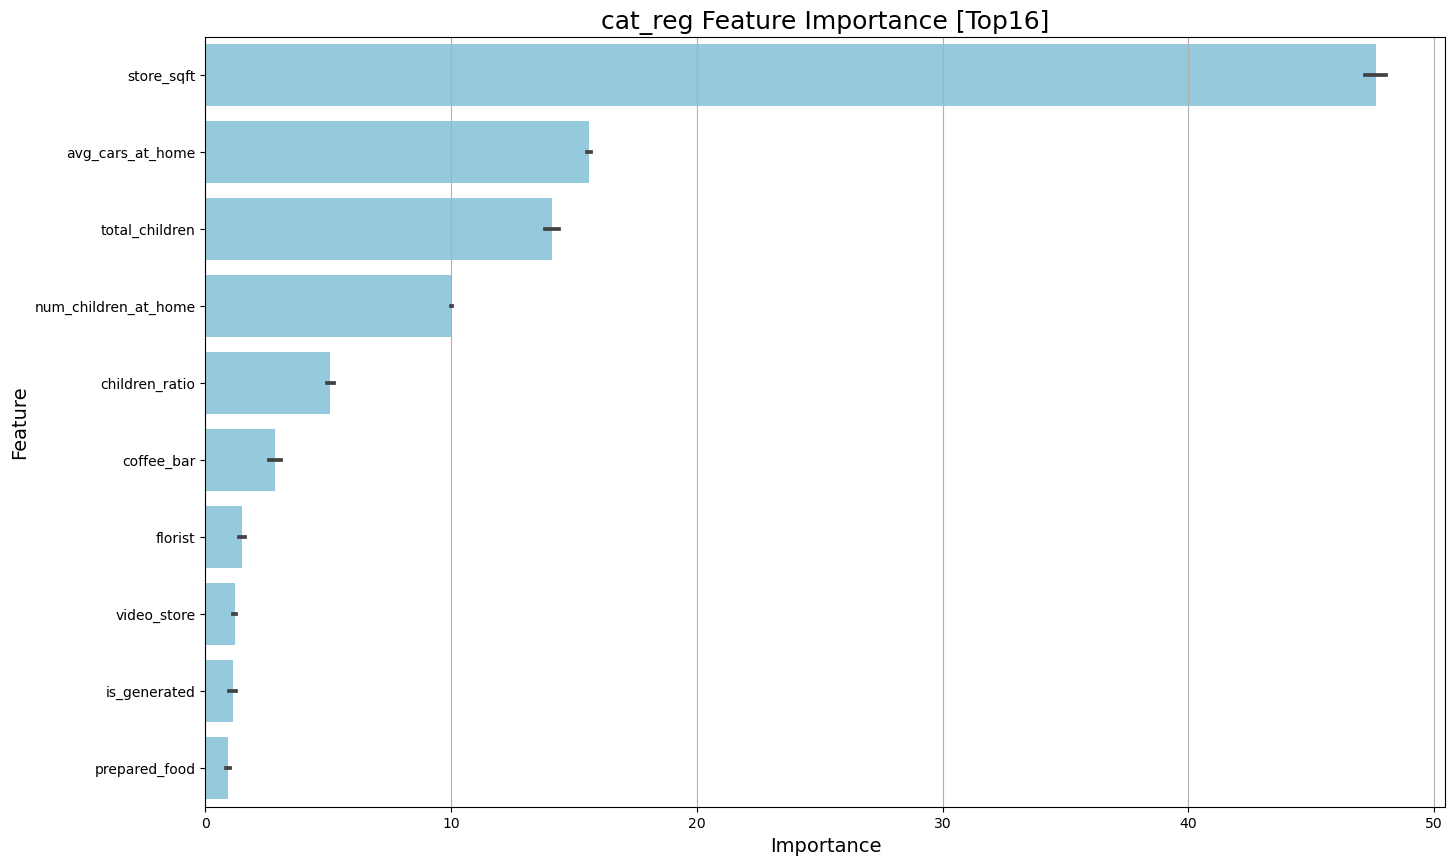

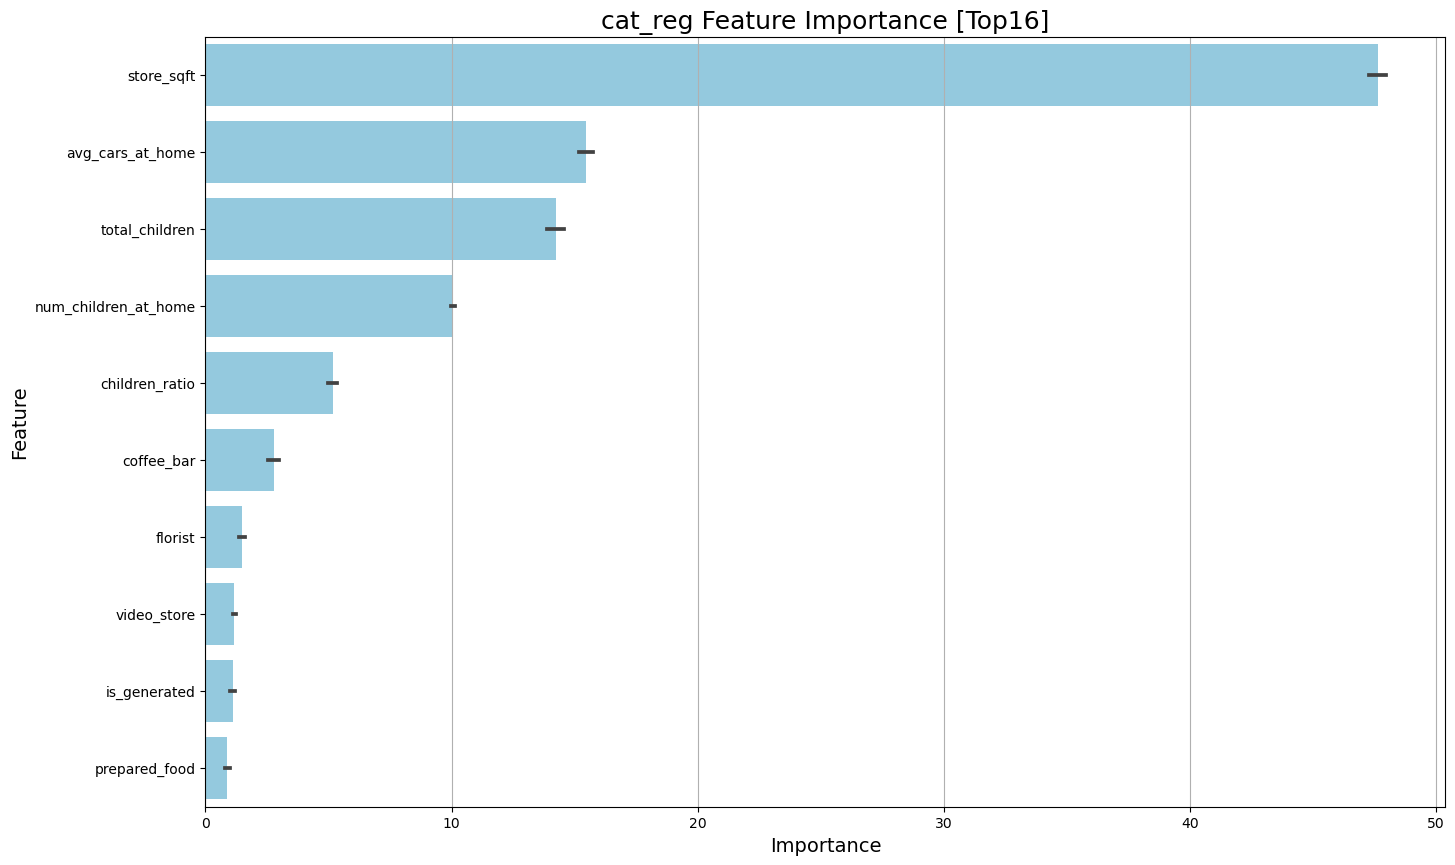

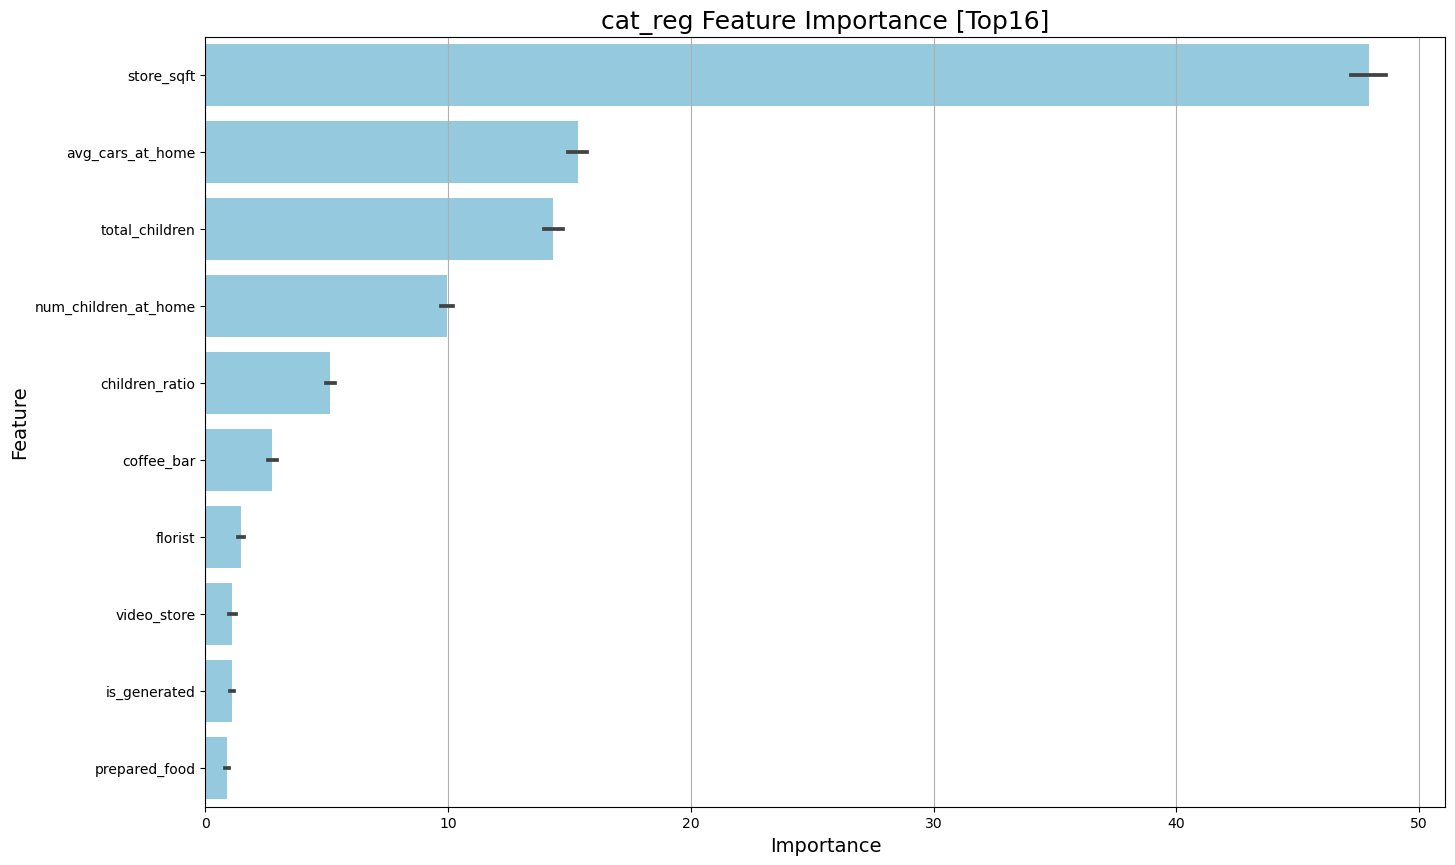

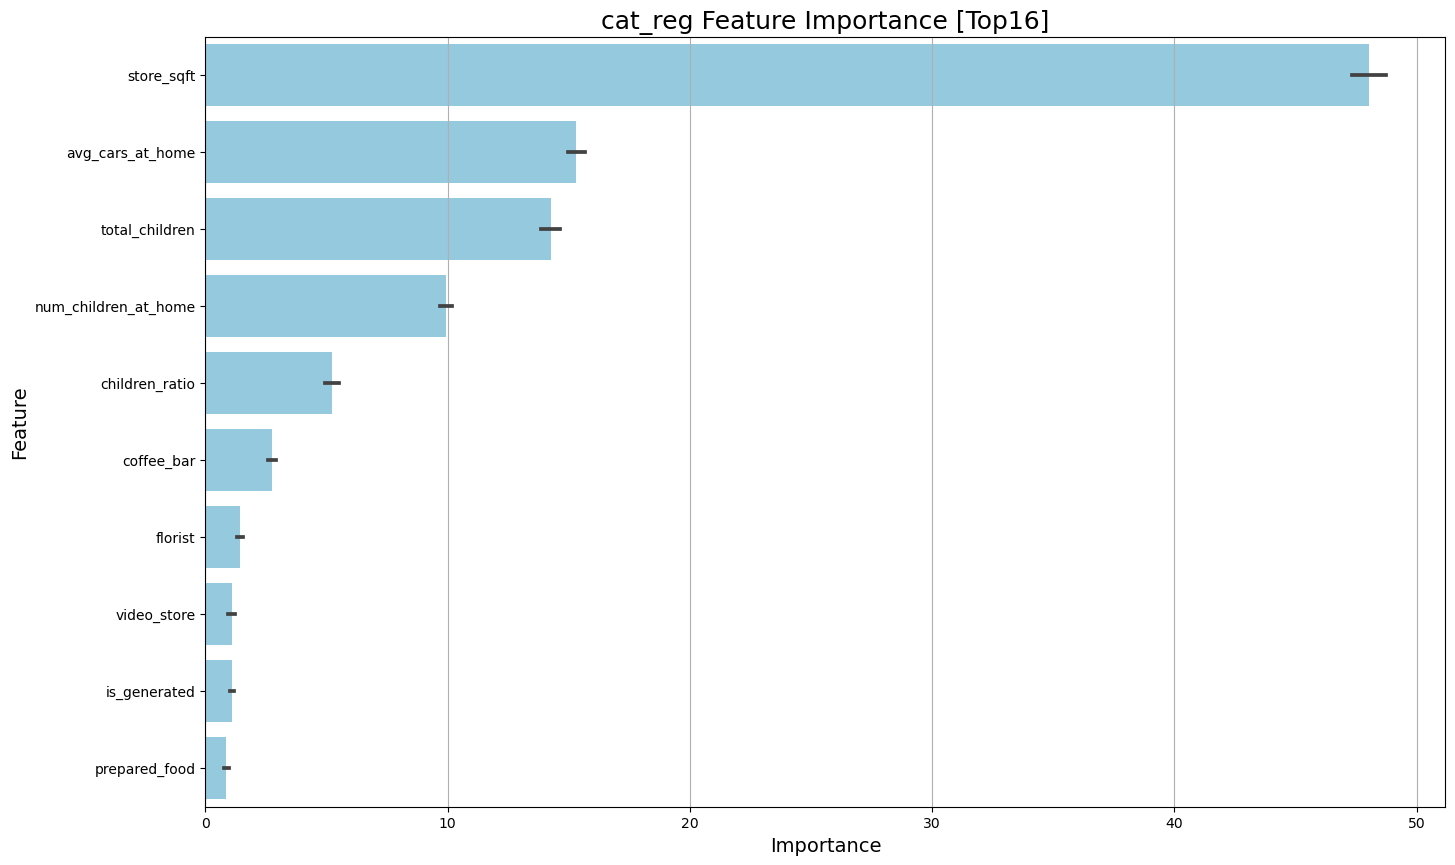

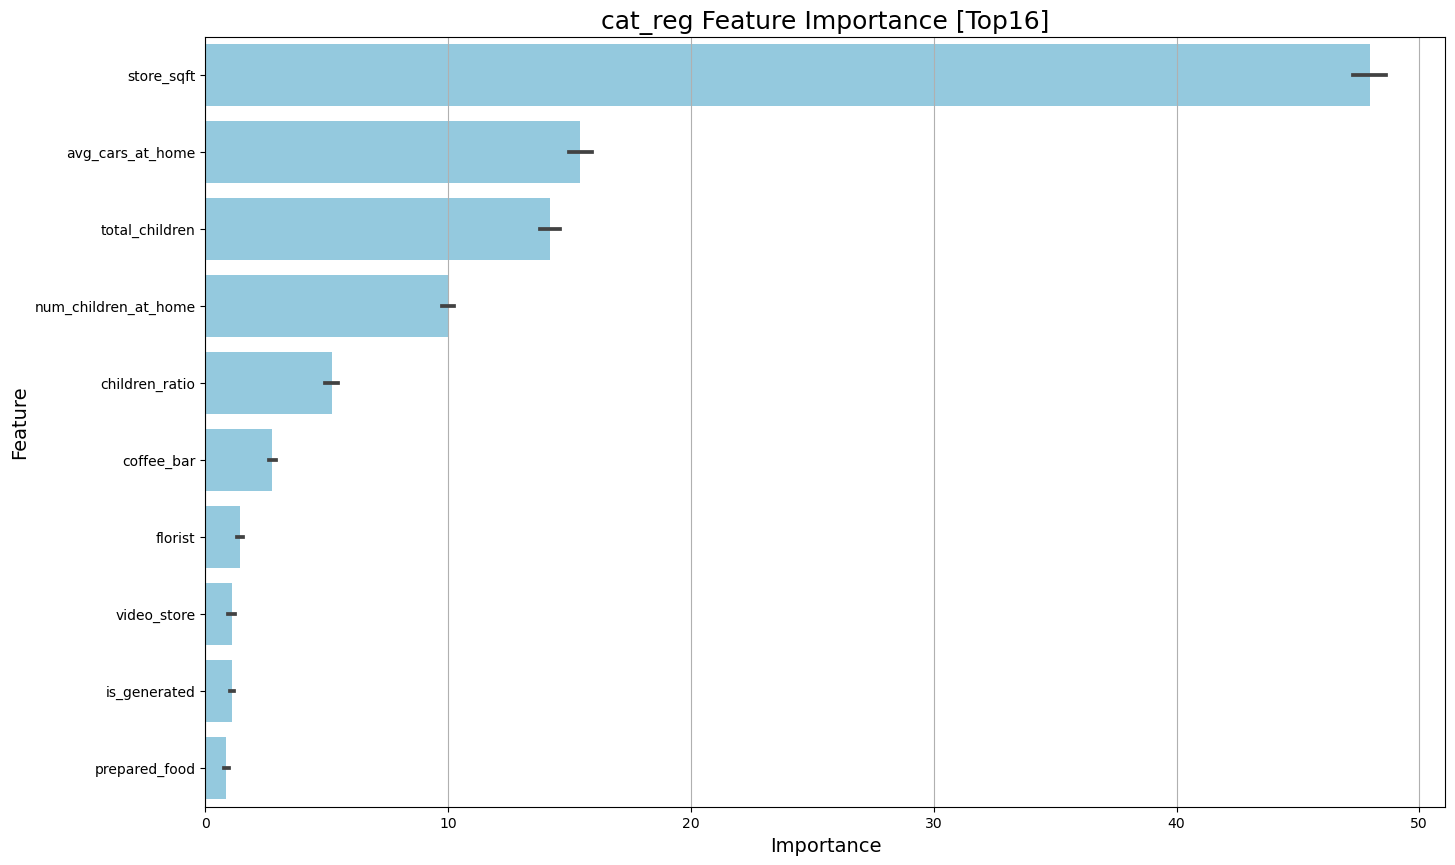

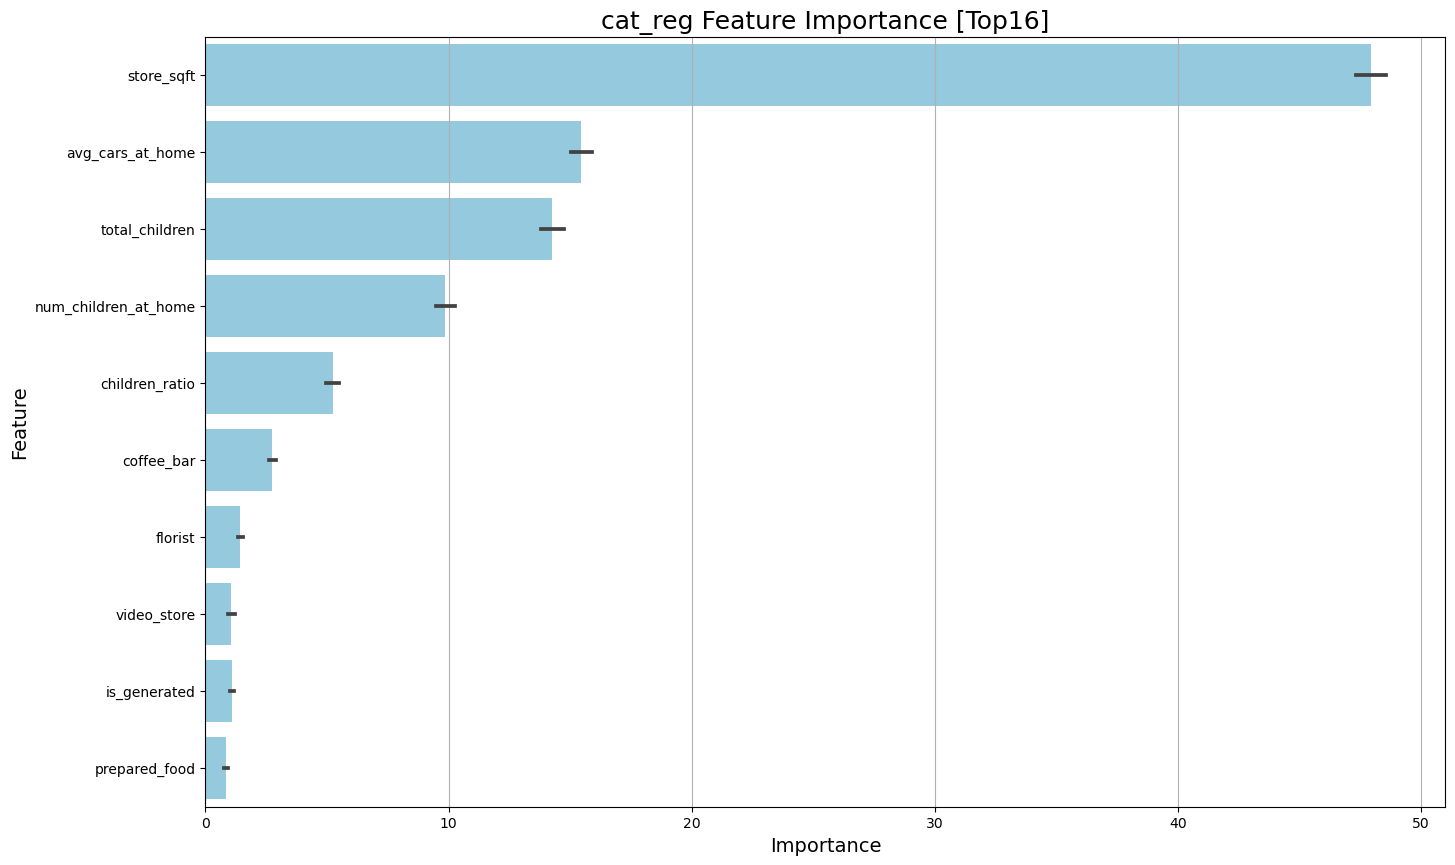

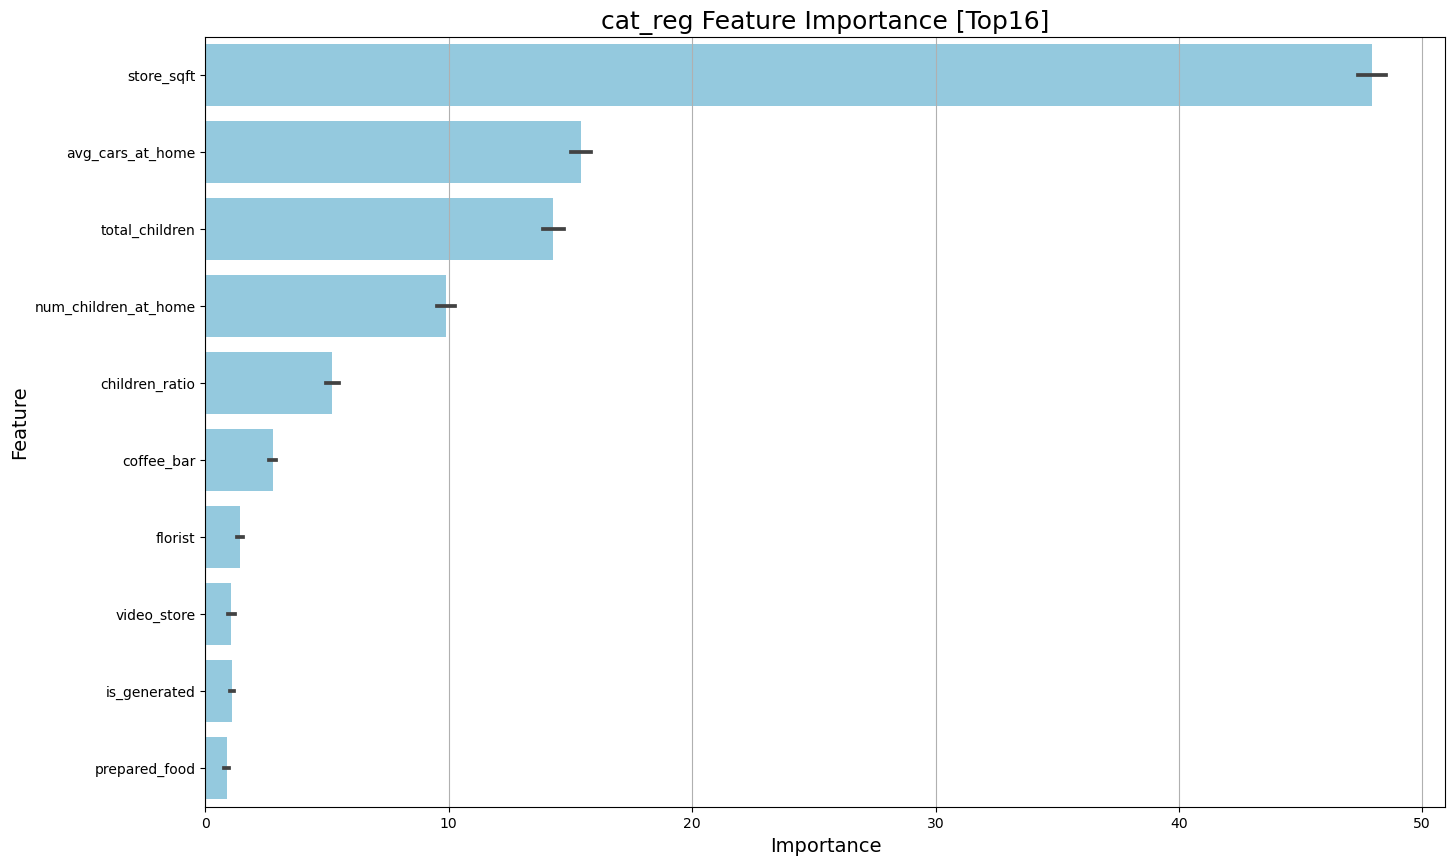

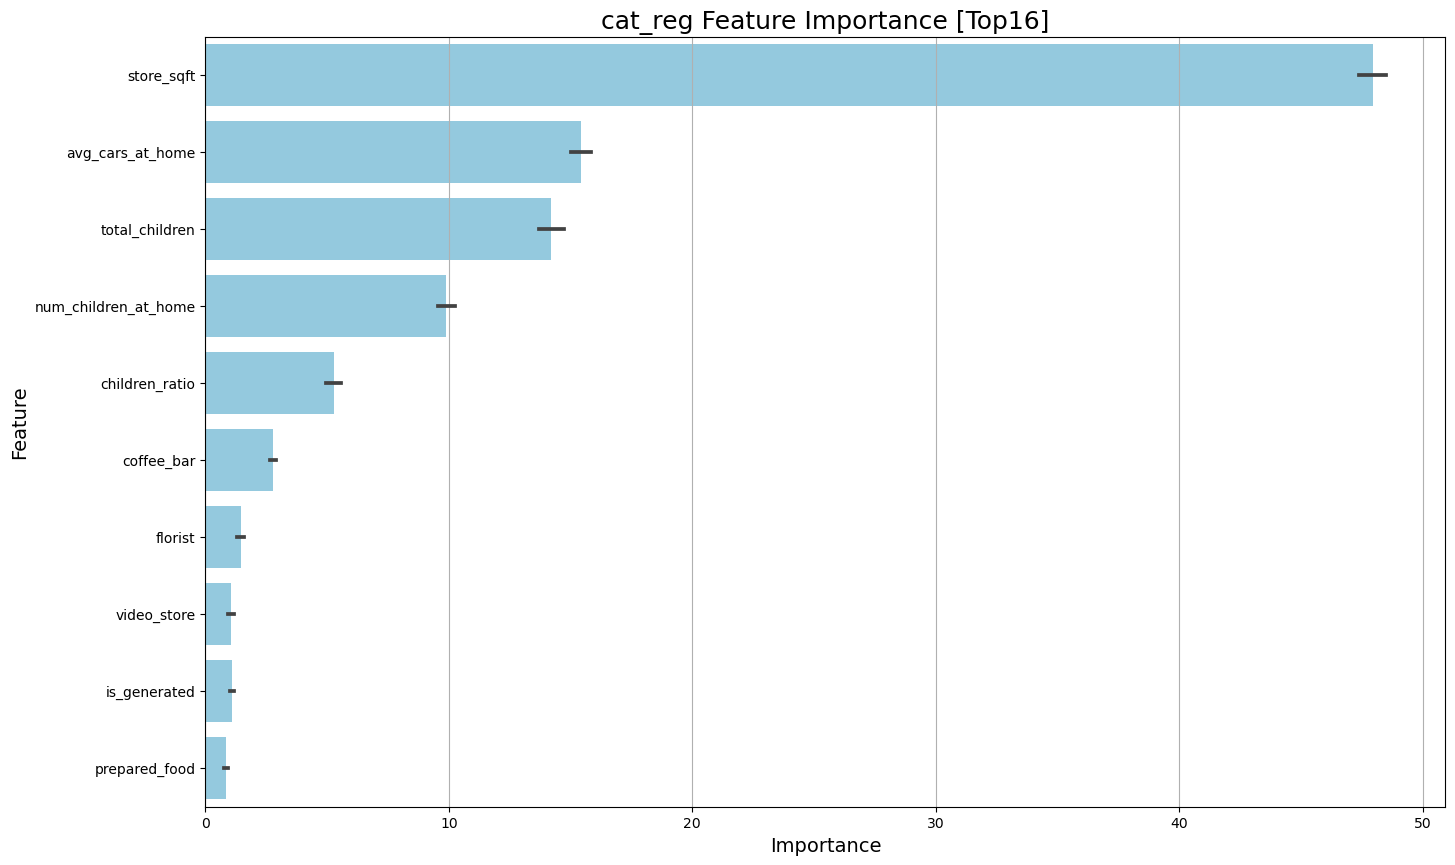

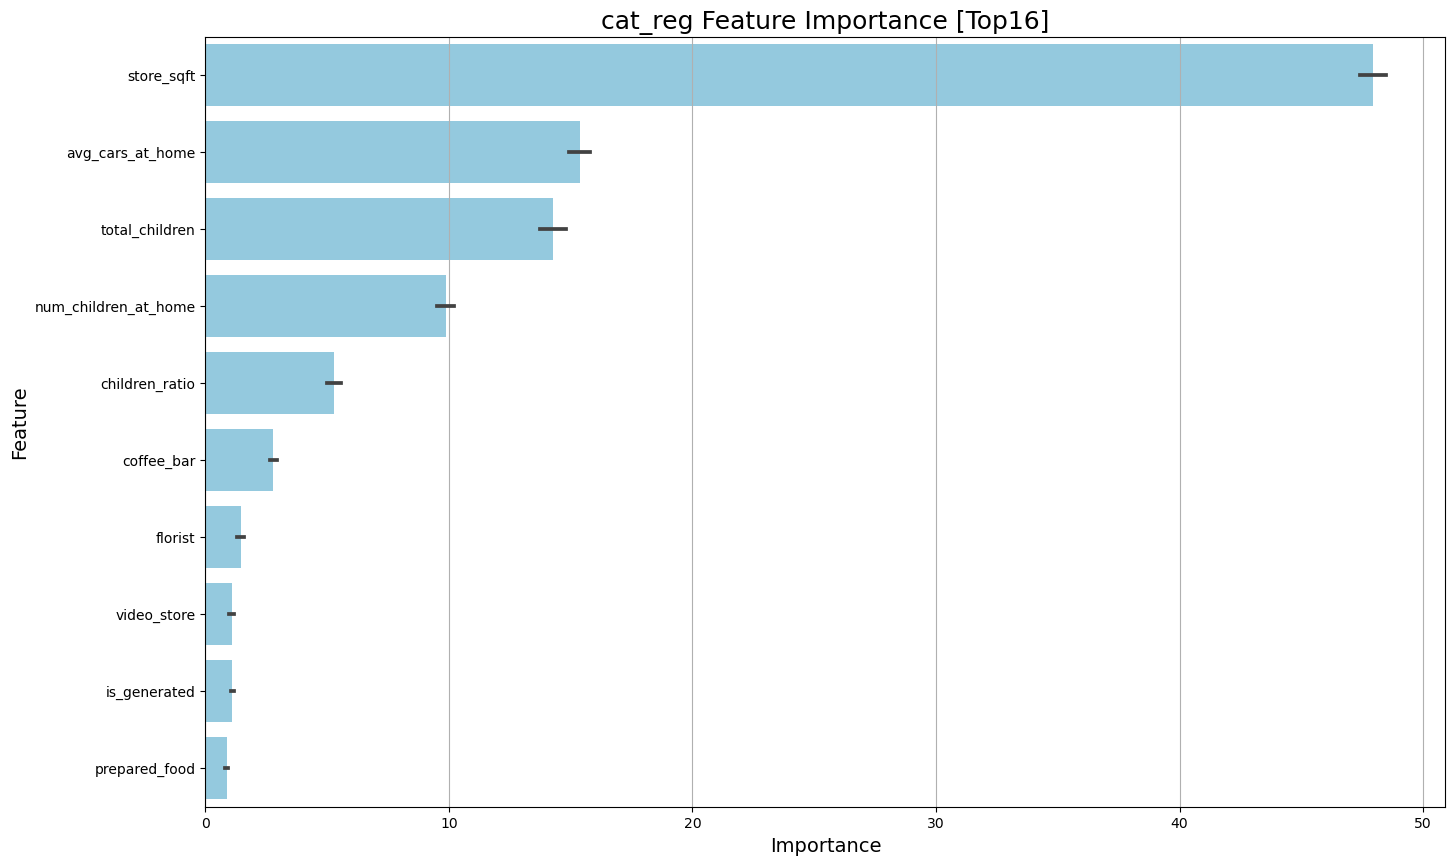

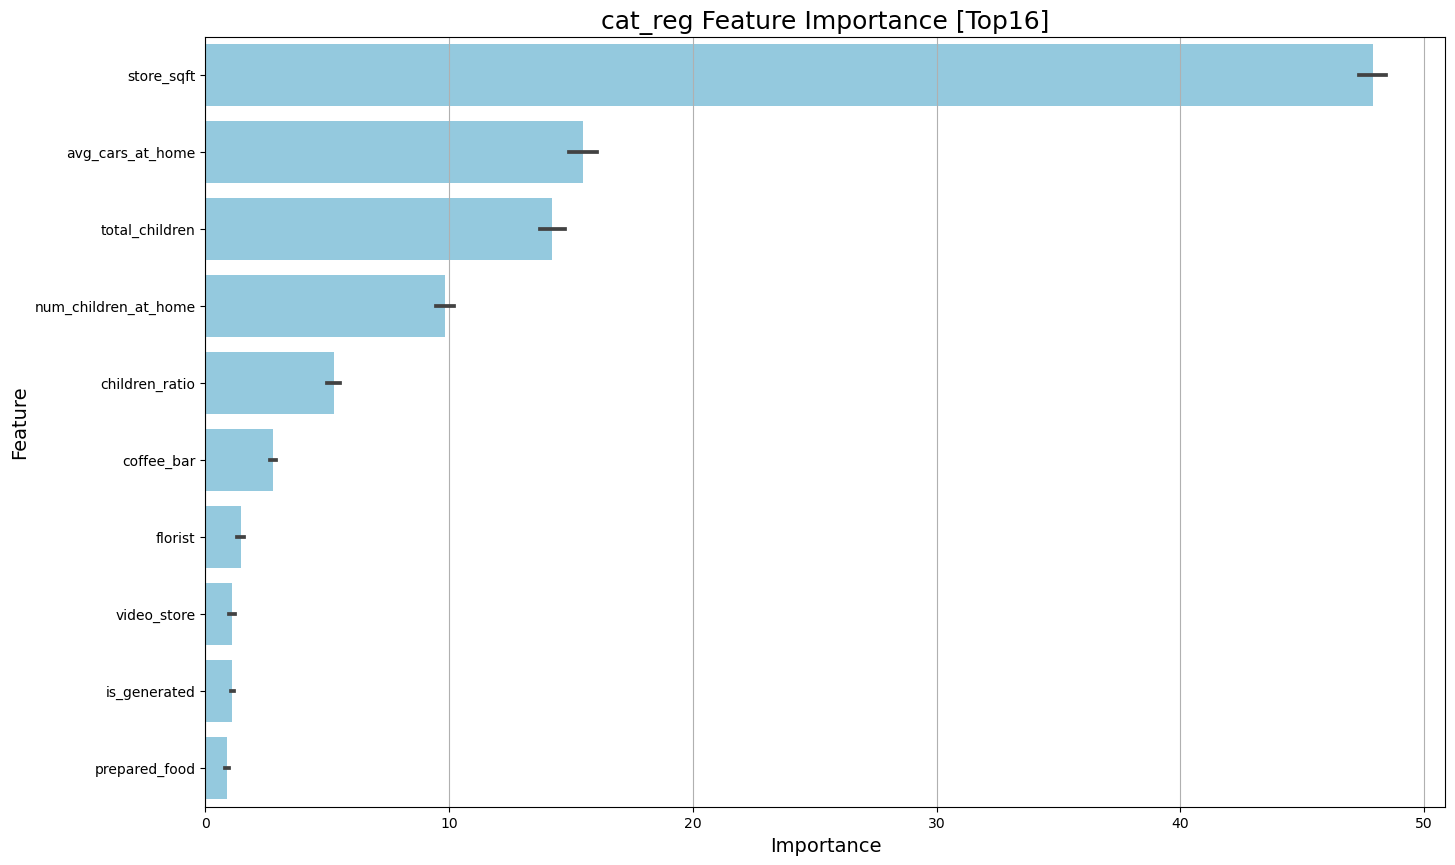

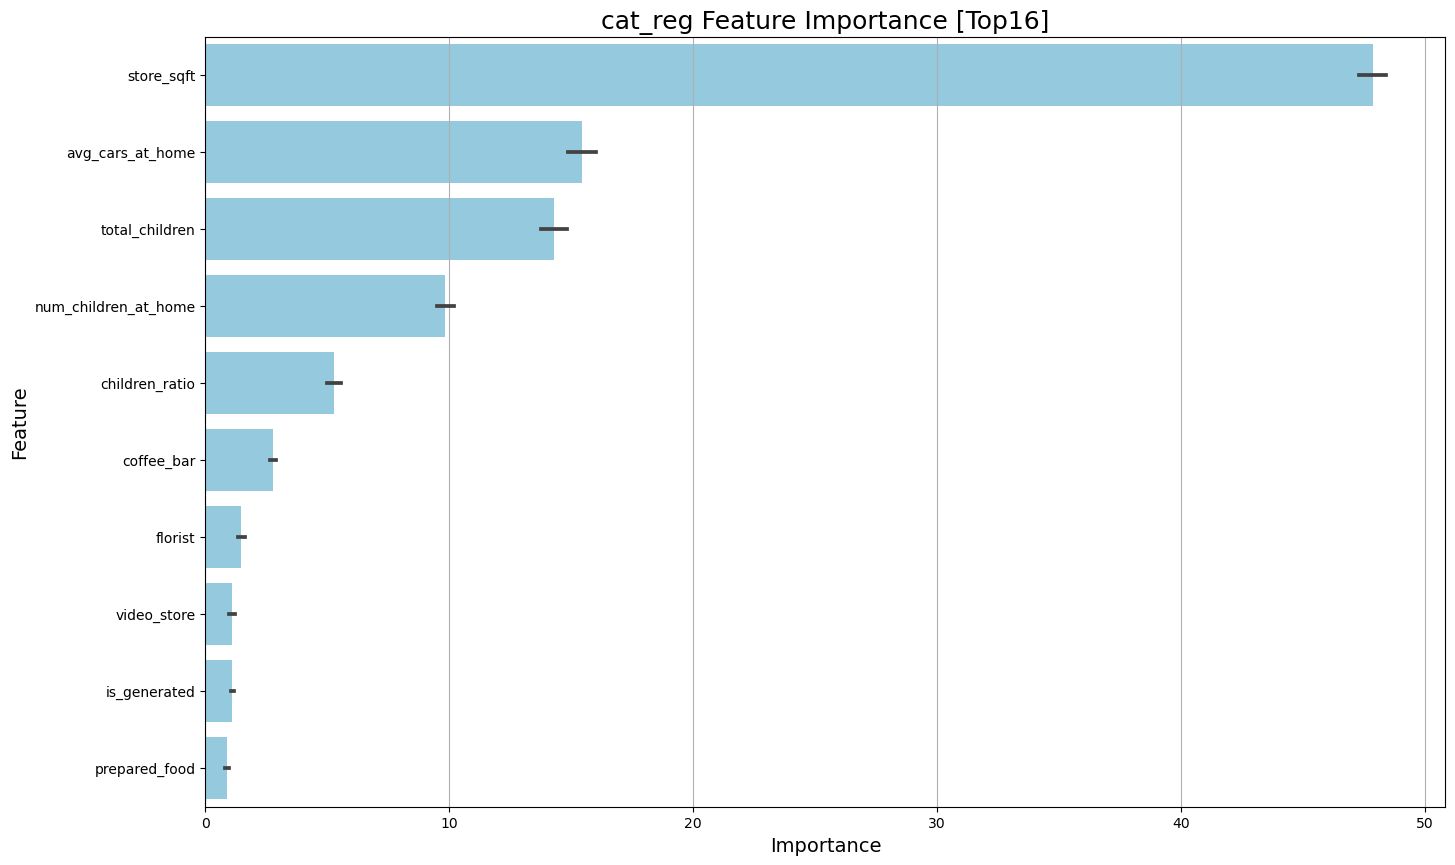

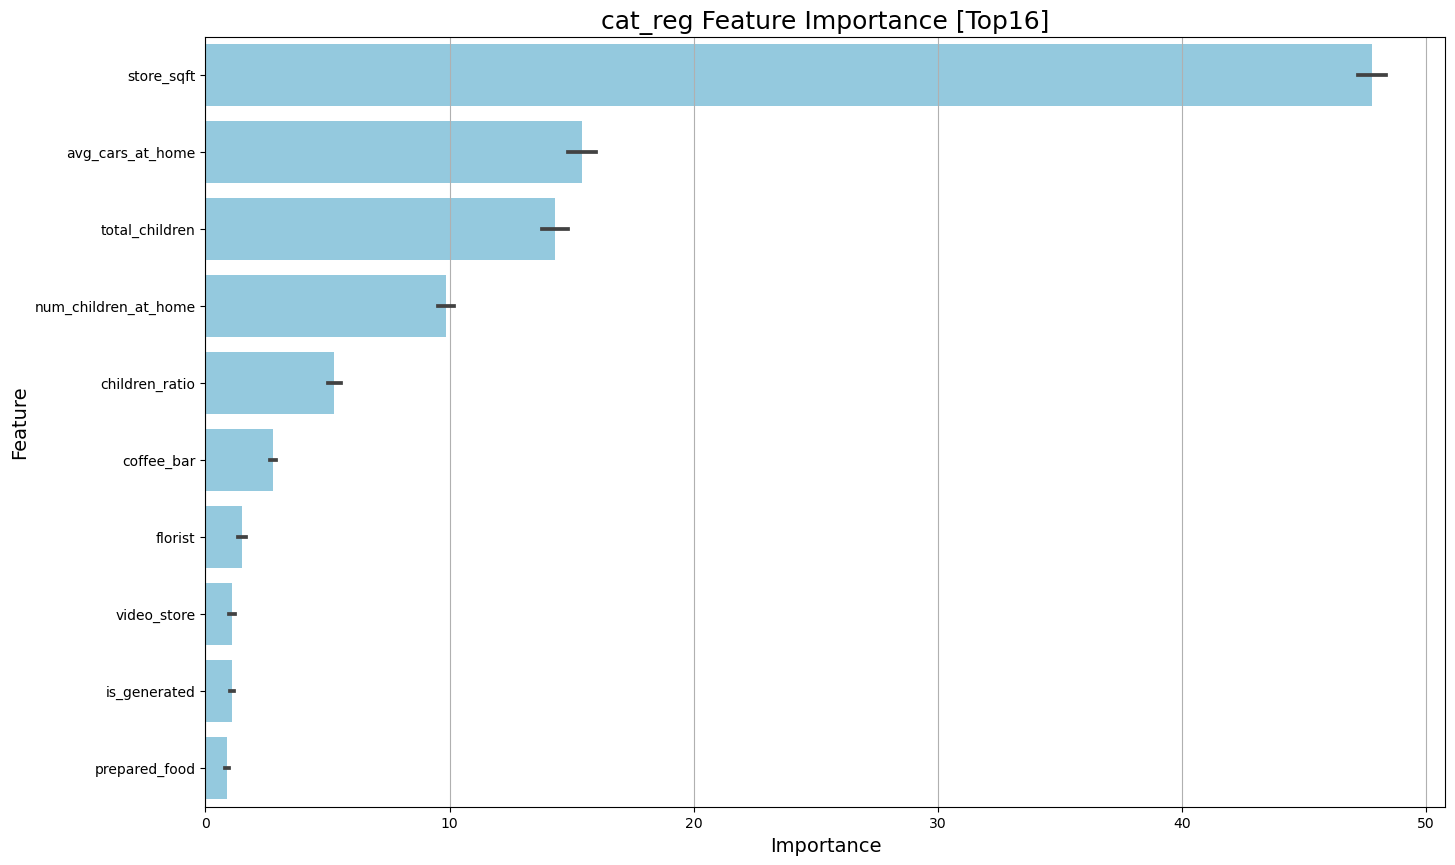

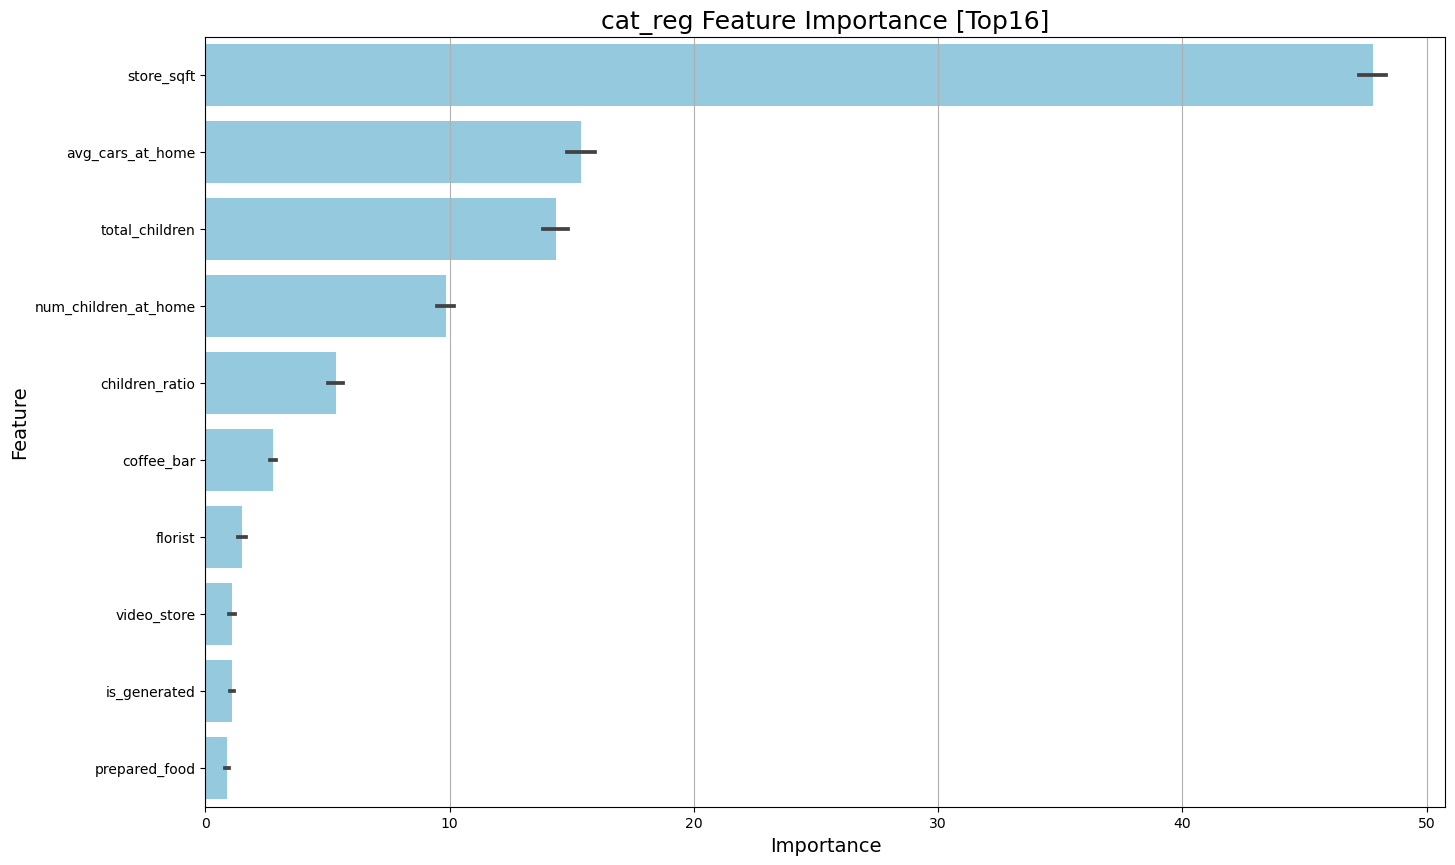

In [12]:
def visualize_importance(models, feature_cols, title, top = 16):
    importances = []
    feature_importance = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['importance'] = model.feature_importances_
        _df['feature'] = pd.Series(feature_cols)
        _df['fold'] = i
        _df = _df.sort_values('importance', ascending = False)
        _df = _df.head(top)
        feature_importance = pd.concat([feature_importance, _df], axis = 0, ignore_index = True)
        feature_importance = feature_importance.sort_values('importance', ascending = False)
        #display(feature_importance.groupby(["feature"]).mean().reset_index().drop('fold', axis = 1))
        plt.figure(figsize = (16, 10))
        sns.barplot(x = 'importance', y = 'feature', data = feature_importance, color = 'skyblue', errorbar = 'sd')
        plt.xlabel('Importance', fontsize = 14)
        plt.ylabel('Feature', fontsize = 14)
        plt.title(f'{title} Feature Importance [Top{top}]', fontsize = 18)
        plt.grid(True, axis = 'x')
        plt.show()
        
for name, models in trained_models.items():
    visualize_importance(models, list(X_train.columns), name)

# Make Submission

In [13]:
sub = pd.read_csv(os.path.join(filepath, 'sample_submission.csv'))
sub[f'{target_col}'] = test_predss
sub.to_csv('submission.csv', index = False)
sub

,id,cost
0,360336,90.598217
1,360337,93.986793
2,360338,94.120536
3,360339,98.396084
4,360340,78.134078
...,...,...
240219,600555,100.381389
240220,600556,90.432189
240221,600557,94.120536
240222,600558,105.346376


<AxesSubplot:xlabel='cost', ylabel='Count'>

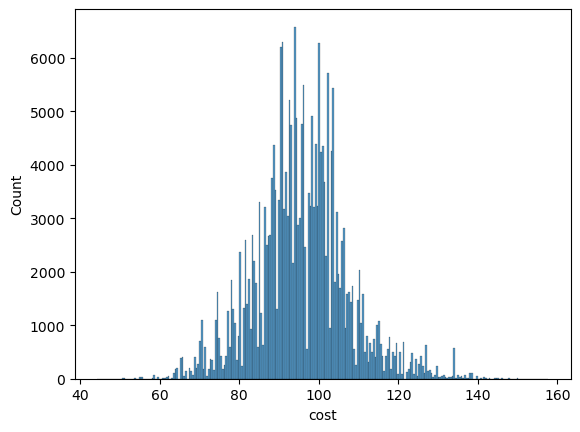

In [14]:
sns.histplot(sub[f'{target_col}'])